<h1>Прогнозирование оттока клиентов телеком-оператора ТелеДом</h1>

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.


<b>Цели и задачи проекта</b>

Основная цель проекта – разработать модель машинного обучения, которая сможет предсказывать вероятность оттока клиентов телеком-оператора TeleDom на основе анализа их поведения и использования услуг.


Задачи проекта включают:


- Анализ предоставленных данных о клиентах и их использовании услуг.<br>
- Предобработка данных для подготовки к обучению модели.<br>
- Выбор и обучение модели машинного обучения для прогнозирования оттока. <br>
- Оценка эффективности модели с использованием соответствующих метрик.<br>

Критерии успеха:<br>
 Проект будет считаться успешным, если достигнуты следующие показатели:

- AUC-ROC выше 0.85.

# **Шаг 1. Загрузка данных**






In [1]:
!pip install pyspark
!pip install phik
!pip install catboost
!pip install --upgrade scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import sklearn
import pickle
import typing
from typing import Dict, Any
from sklearn.preprocessing import OneHotEncoder
from pyspark.sql import SparkSession
from phik import resources, report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3d25187996502ec87886e3f3bea07e6dbb642999f4ec4e93d4470f0b2fffaa05
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
  Using cached phik-0.12.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (686 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
RANDOM_STATE=190224

In [5]:
sns.set_palette('tab20c')

In [6]:
#load datasets
contract = pd.read_csv('/content/drive/MyDrive/datasets/contract_new.csv')

display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
#size of dataset contract
contract.shape

(7043, 8)

In [8]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
print(contract.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [10]:
duplicate_count = contract.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0



Первичный анализ данных был проведен в наборе данных «контракт». 7043 строки, 8 столбцов. Некоторые типы данных следует изменить, чтобы они лучше соответствовали содержащейся в них информации. Данные следует проверить на наличие явных и скрытых дубликатов.

In [11]:
#load dataset
internet = pd.read_csv('/content/drive/MyDrive/datasets/internet_new.csv')
display(internet.head())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
#size of dataset internet
internet.shape

(5517, 8)

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
print(internet.isnull().sum())

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [15]:
duplicate_count = internet.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Первичный анализ данных был проведен в наборе данных «Интернет». 5517 строк, 8 столбцов. Некоторые типы данных следует изменить, чтобы они лучше соответствовали содержащейся в них информации.

In [16]:
personal = pd.read_csv('/content/drive/MyDrive/datasets/personal_new.csv')
display(personal.head())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [17]:
#size of dataset personal
personal.shape

(7043, 5)

In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [19]:
print(personal.isnull().sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [20]:
duplicate_count = personal.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Первичный анализ данных был проведен в «personal» наборе данных. 7043 строки, 5 столбцов. Некоторые типы данных следует изменить, чтобы они лучше соответствовали содержащейся в них информации. Данные следует проверить на наличие явных и скрытых дубликатов.

In [21]:
phone = pd.read_csv('/content/drive/MyDrive/datasets/phone_new.csv')
display(phone.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
#size of dataset phone
phone.shape

(6361, 2)

In [23]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [24]:
print(phone.isnull().sum())

customerID       0
MultipleLines    0
dtype: int64


In [25]:
duplicate_count = phone.duplicated(subset='customerID', keep=False).sum()
print(duplicate_count)

0


Первоначальный анализ данных был проведен в наборе данных «Phone». 6361 строка, 2 столбца.Пропущенные данные отсутствуют. Дубликаты по customerID отсуствуют

Данные из 4 наборов данных были успешно загружены. Данные необходимо предварительно обработать. Это будет сделано в следующем разделе.

# **Шаг 2. Исследовательский анализ данных и предобработка**

## Датасет Contract















В данном датасете необходимо выполнить следующие шаги для исследовательского анализа данных и предобработки:<br>
-Перевод названия колонок в нижний регистр, так как это является общепринятой практикой.  
-Поиск явных дубликатов  
-Поиск пропущенных данных  
-Удаление явных дубликатов, если они есть  
-Перевод формата столбцов с датами в формат datetime64  
-Перевод totalcharges в числовой формат  
-Если в этой колонке будут найдены  пропуски - это будет означать, что существуют клиенты, которые еще не успели внести ни одну плату, и следовательно эти данные можно будет заменить 0  
-Необходимо завести целевую переменную - отток клиентов - если они разорвали контракт в колонке enddate будет стоять дата окончания контракта   
-Если дата окончания контракта не стоит, следовательно клиент продолжает пользоваться услугами, и можно заменить пропущенные данные на дату 2020-02-01 - контракты актуальны до этой даты.
-Для числовых данных провести анализ на разброс данных и выбросы с помощью графика Boxplot  
-Провести анализ распределения целевой переменной Churn.





In [26]:
#converting column names to lowercase
contract.columns = contract.columns.str.lower()

In [27]:
#looking for obvious duplicates
duplicates = contract.duplicated()
print(duplicates.sum())

0


In [28]:
#delete dublicates
contract = contract.drop_duplicates()
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 495.2+ KB


In [29]:
# Convert 'begindate' and 'enddate' to datetime
contract['begindate'] = pd.to_datetime(contract['begindate'])
contract['enddate'] = pd.to_datetime(contract['enddate'], errors='coerce')

# Convert 'totalcharges' to numeric, errors='coerce' will replace non-numeric values with NaN
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'], errors='coerce')

# Check the new data types
print(contract.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 495.2+ KB
None


In [30]:
# Replacing all types of missing values with 0
contract['totalcharges'].fillna(0, inplace=True)

Найденные пропуски totalcharges  предположительно означают,что существуют клиенты, которые еще не успели внести ни одну плату, и следовательно эти данные можно будет заменить 0

In [31]:
# Creating a target column 'churn' indicating whether a customer has churned
# 1 if 'end_date' has a date (the contract was terminated), 0 otherwise
contract['churn'] = contract['enddate'].notna().astype(int)

# Checking the distribution of the target variable
print(contract['churn'].value_counts())

0    5942
1    1101
Name: churn, dtype: int64


In [32]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1101 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 550.2+ KB


In [33]:
#replace missing end_date because the information in contracts is actual  to 2020-02-01
replacement_date = pd.Timestamp('2020-02-01')
contract['enddate'] = contract['enddate'].fillna(replacement_date)

In [34]:
contract.head(3)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0


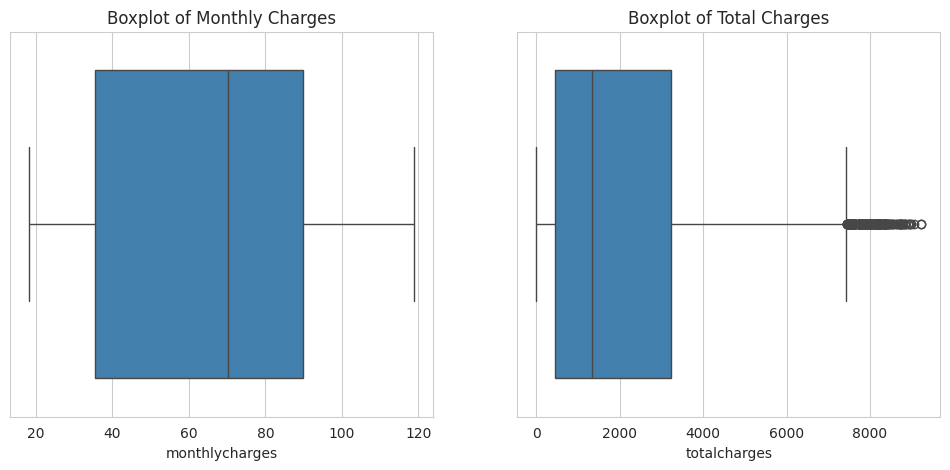

In [35]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating boxplots for 'monthlycharges' and 'totalcharges'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=contract['monthlycharges'])
plt.title('Boxplot of Monthly Charges')

plt.subplot(1, 2, 2)
sns.boxplot(x=contract['totalcharges'])
plt.title('Boxplot of Total Charges')

plt.show()

Был проведен анализ аномалий и выбросов, при этом особое внимание было уделено столбцу TotalCharges. В результате анализа стало ясно, что в данных наблюдается значительная вариабельность данных, что может указывать на наличие долгосрочных клиентов с высокими общими затратами.

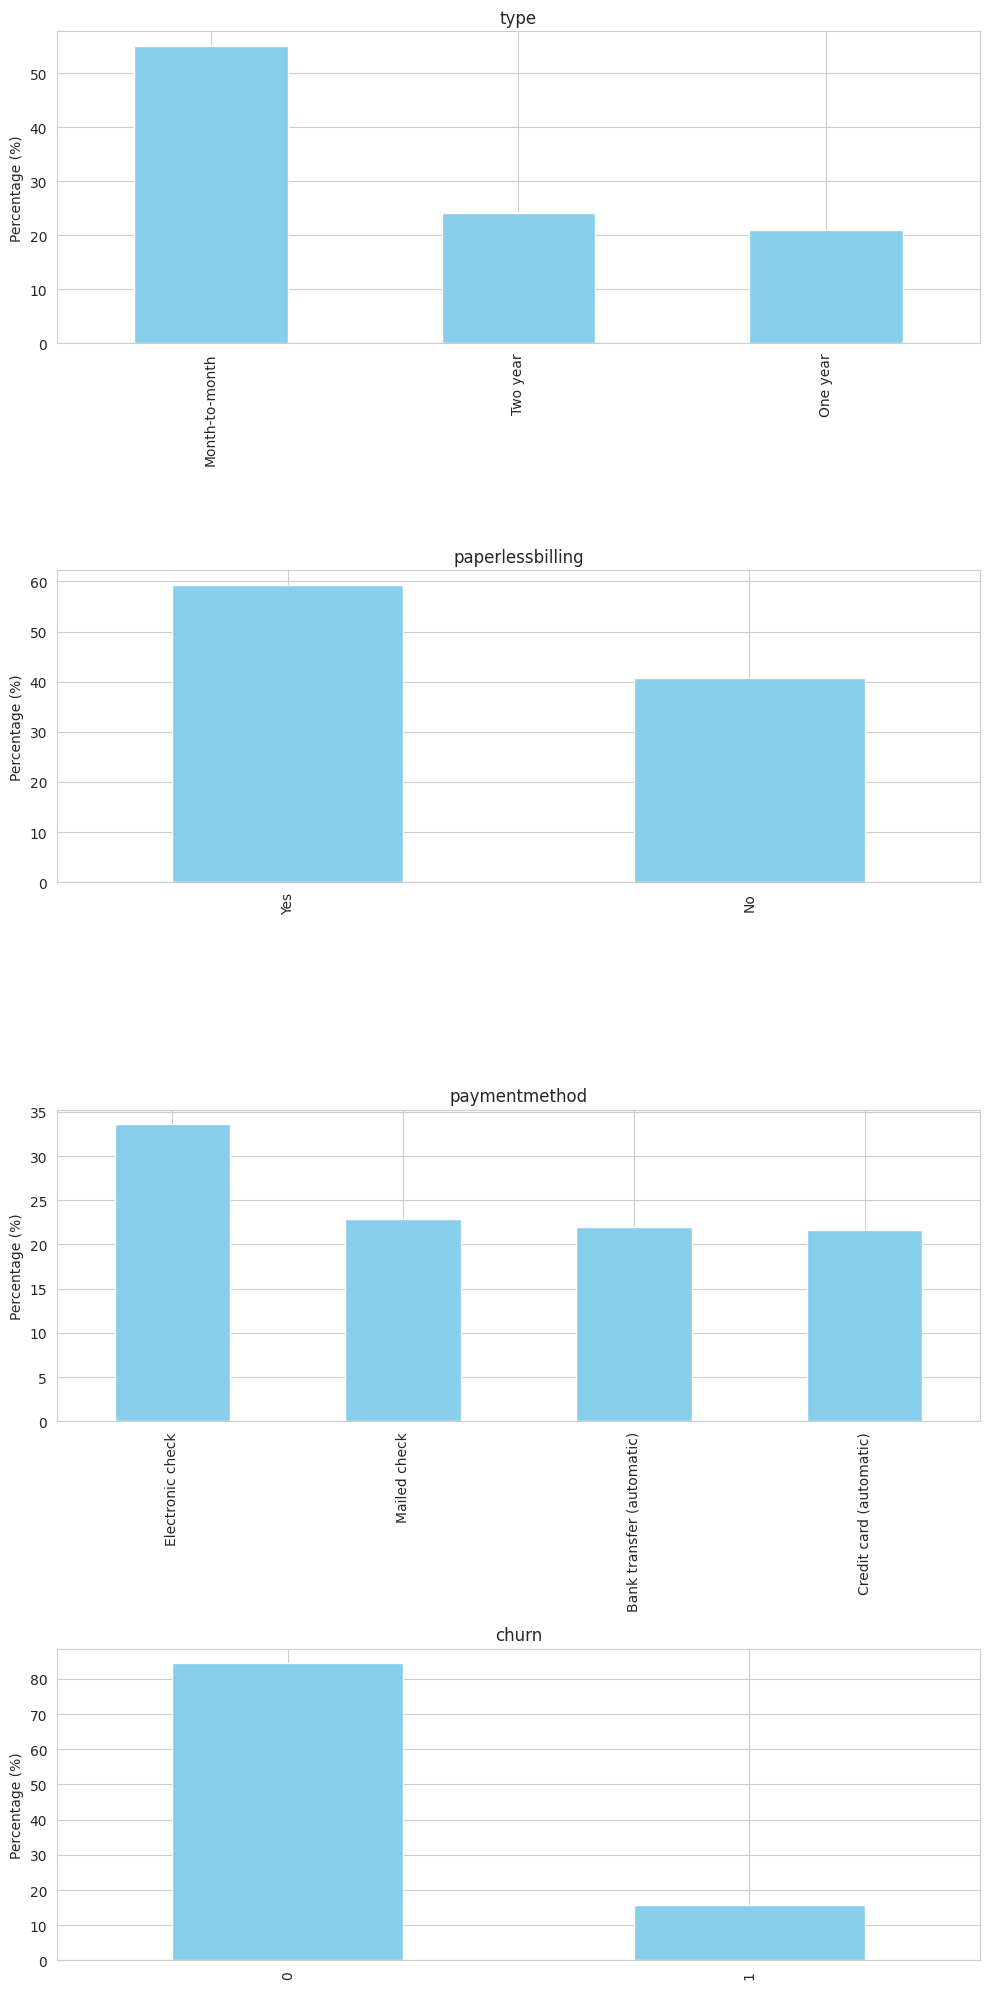

In [36]:
columns = ['type', 'paperlessbilling', 'paymentmethod', 'churn']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = contract[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Среди типов оплаты контракта преобладает  -ежемесячный

Электронный тип оплаты преобадает,остальные 3 типа оплаты занимают примерно одинаковые пропорции

Электронный расчётный лист запрашивает больше половины клиентов.

In [37]:
contract['churn'].describe()

count    7043.000000
mean        0.156325
std         0.363189
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

В рамках раздела «Исследовательский анализ и предварительная обработка данных» для набора данных «Contract» были выполнены следующие действия и сделаны соответствующие выводы:

Предварительная проверка данных. Набор данных был тщательно проверен на предмет типов данных, пропущенных значений и общего содержания. Было обнаружено, что данные содержат как числовые, так и категориальные характеристики, а также отсутствующие значения в столбце EndDate.

Обработка пропущенных значений. Отсутствующие значения в EndDate интерпретировались как индикаторы текущих контрактов (клиенты продолжают пользоваться услугами). Эти значения заменены на дату 01.02.2020 - данные в договорах актуальны до этой даты.

Анализ и обработка аномалий. Был проведен анализ аномалий и выбросов, при этом особое внимание было уделено столбцу TotalCharges. В результате анализа стало ясно, что в данных наблюдаются значительные разбросы, что может указывать на наличие долгосрочных клиентов с высокими общими затратами.

Среди типов оплаты контракта преобладает -ежемесячный.Электронный расчётный лист запрашивает больше половины клиентов. Электронный тип оплаты преобадает.

Анализ целевой переменной: был проведен анализ распределения целевой переменной (отток клиентов), который показал, что около 15,63% клиентов расторгли договор. Это обеспечивает основу для дальнейшего построения модели прогнозирования оттока клиентов.

## Датасет **Internet**

В данном датасете необходимо выполнить следующие шаги для исследовательского анализа данных и предобработки:<br> -Перевод названия колонок в нижний регистр, так как это является общепринятой практикой.   
-Поиск пропущенных данных  
-Дубликаты в данном датасете не требуют удаления,так как данные в колонках не носят персонафицированный характер и могут быть одинакомыми для нескольких клиентов   
-Проанализировать  распределение категориальных данных

In [38]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [39]:
#converting column names to lowercase
internet.columns = internet.columns.str.lower()

In [40]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


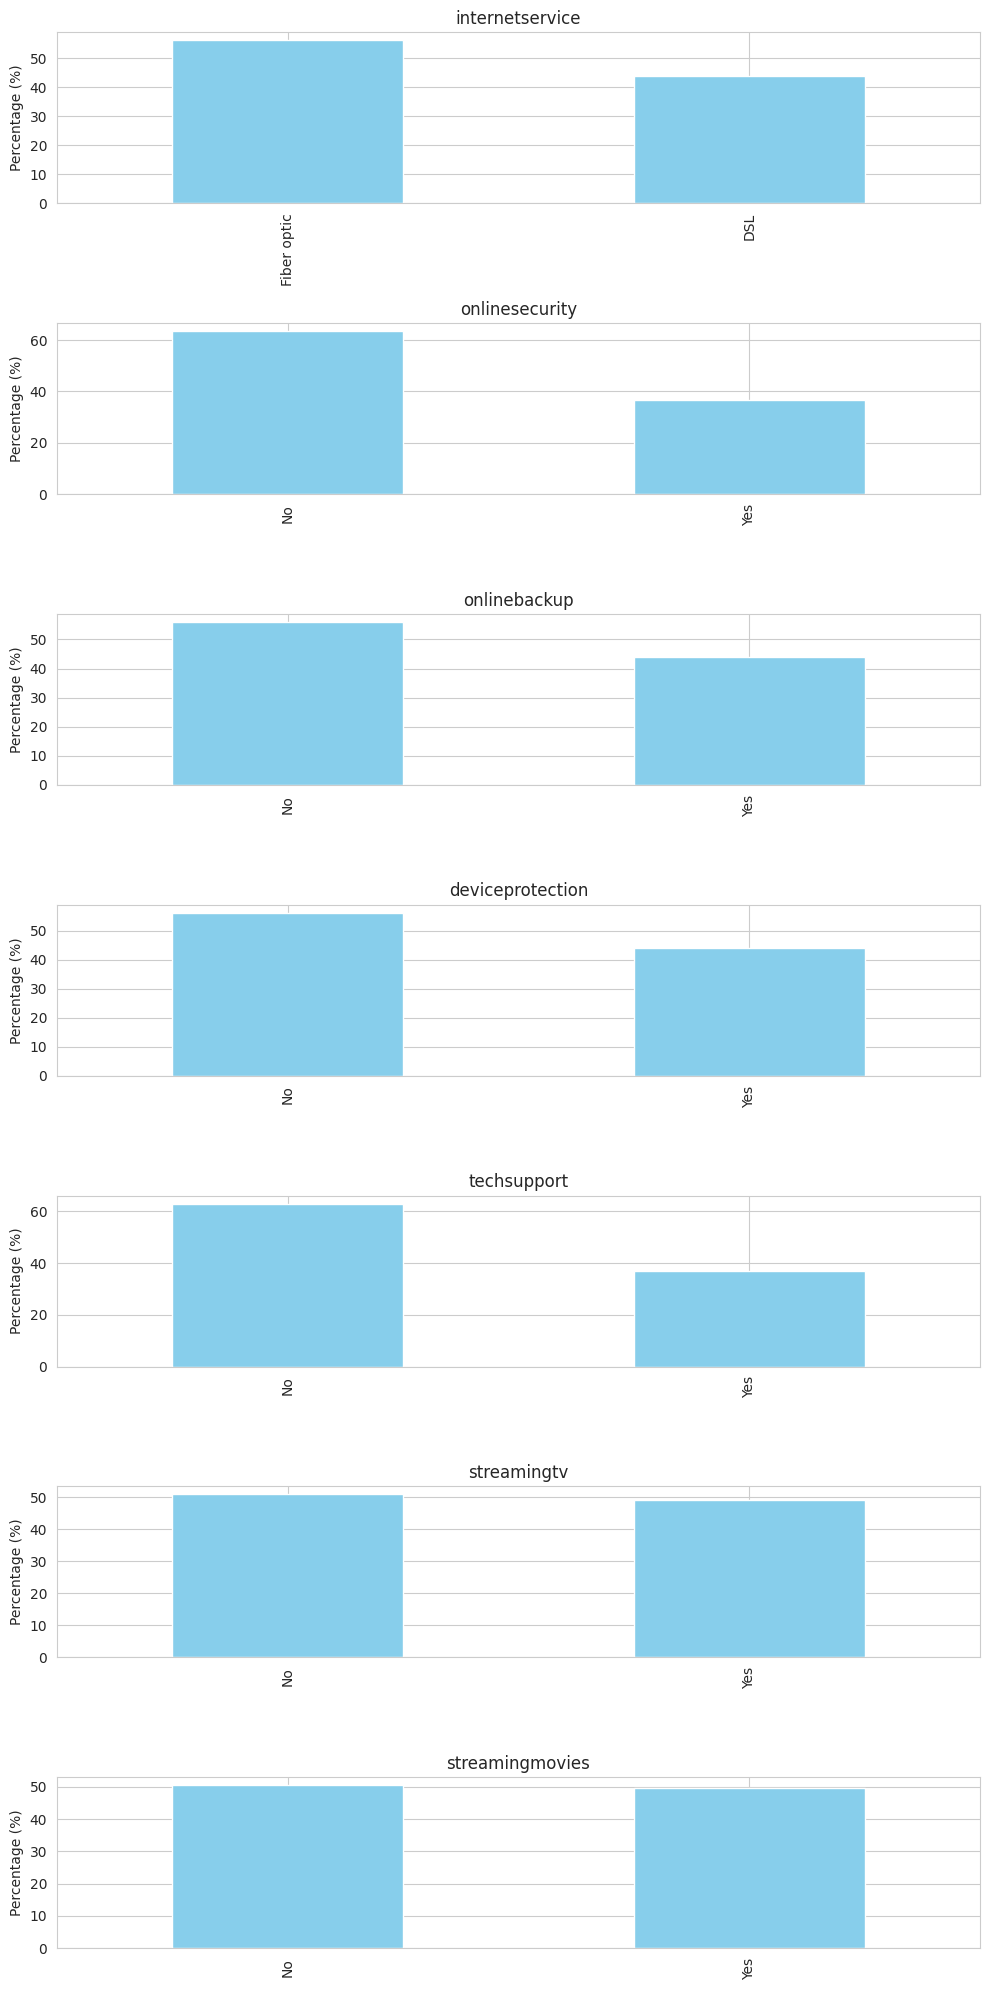

In [41]:
columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
           'techsupport', 'streamingtv', 'streamingmovies']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = internet[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Использование оптоволокна: примерно 56,12% пользователей используют оптоволоконное подключение к Интернету. Это свидетельствует о высокой популярности оптоволокна среди рассматриваемой выборки пользователей.

Интернет-безопасность: около 36,60% пользователей подписываются на службу онлайн-безопасности. Это показывает, что услуга не так популярна, как могла бы быть, возможно, из-за дополнительной стоимости или недостаточной осведомленности пользователей о преимуществах.

Онлайн-резервное копирование. Службой онлайн-резервного копирования пользуются примерно 44,03% пользователей. Это говорит об умеренной популярности сервиса.

Защита устройства. Примерно 43,90% пользователей воспользовались услугой защиты устройств, что практически идентично популярности онлайн-резервного копирования.

Техподдержка: услугами технической поддержки пользуются около 37,05% пользователей, что делает ее сравнительно менее популярной среди предлагаемых услуг.

Интернет-телевидение (потоковое телевидение): почти половина пользователей (49,07%) используют сервис потокового телевидения, что делает его одним из наиболее популярных сервисов среди рассмотренных.

Фильмы через Интернет (Streaming Movies): Чуть более популярным, чем потоковое телевидение, является сервис потокового кино, которым пользуются 49,52% пользователей.

Вывод: в целом данные показывают, что услуги, связанные с развлечениями (такие как потоковое телевидение и фильмы), более популярны, чем услуги безопасности и поддержки (такие как онлайн-безопасность и техническая поддержка). Оптоволоконные подключения к Интернету также очень популярны, что может указывать на желание пользователей иметь высокоскоростное соединение для более требовательных услуг, таких как потоковое видео.

**Summary of Step 2: Exploratory Data Analysis and Preprocessing (Dataset "Internet")**



Анализ показал, что, хотя большинство клиентов предпочитают оптоволоконное соединение, другие услуги, такие как онлайн-резервное копирование и потоковая передача, также пользуются значительной популярностью.
Отсутствие спроса на некоторые дополнительные услуги, такие как онлайн-безопасность и защита устройств, может иметь решающее значение при принятии решений относительно стратегии предоставления услуг и маркетинговой политики.
Предлагаемые услуги могут быть оптимизированы на основе предпочтений клиентов, выявленных в результате анализа данных, с целью повышения удовлетворенности клиентов и сокращения их оттока.

## Датасет **Personal**















В данном датасете необходимо выполнить следующие шаги для исследовательского анализа данных и предобработки:<br> -Перевод названия колонок в нижний регистр, так как это является общепринятой практикой.  
-Поиск пропущенных данных  
-Дубликаты в данном датасете не требуют удаления,так как данные в колонках не носят персонафицированный характер и могут быть одинакомыми для нескольких клиентов  
-Проанализировать распределение категориальных данных  

In [42]:
#converting column names to lowercase
personal.columns = personal.columns.str.lower()

In [43]:
#looking for obvious duplicates
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [44]:
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [45]:
# Viewing unique values for each column
for column in personal.columns:
    print(f"Unique values in column {column}: {personal[column].unique()}")

Unique values in column customerid: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column gender: ['Female' 'Male']
Unique values in column seniorcitizen: [0 1]
Unique values in column partner: ['Yes' 'No']
Unique values in column dependents: ['No' 'Yes']


In [46]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


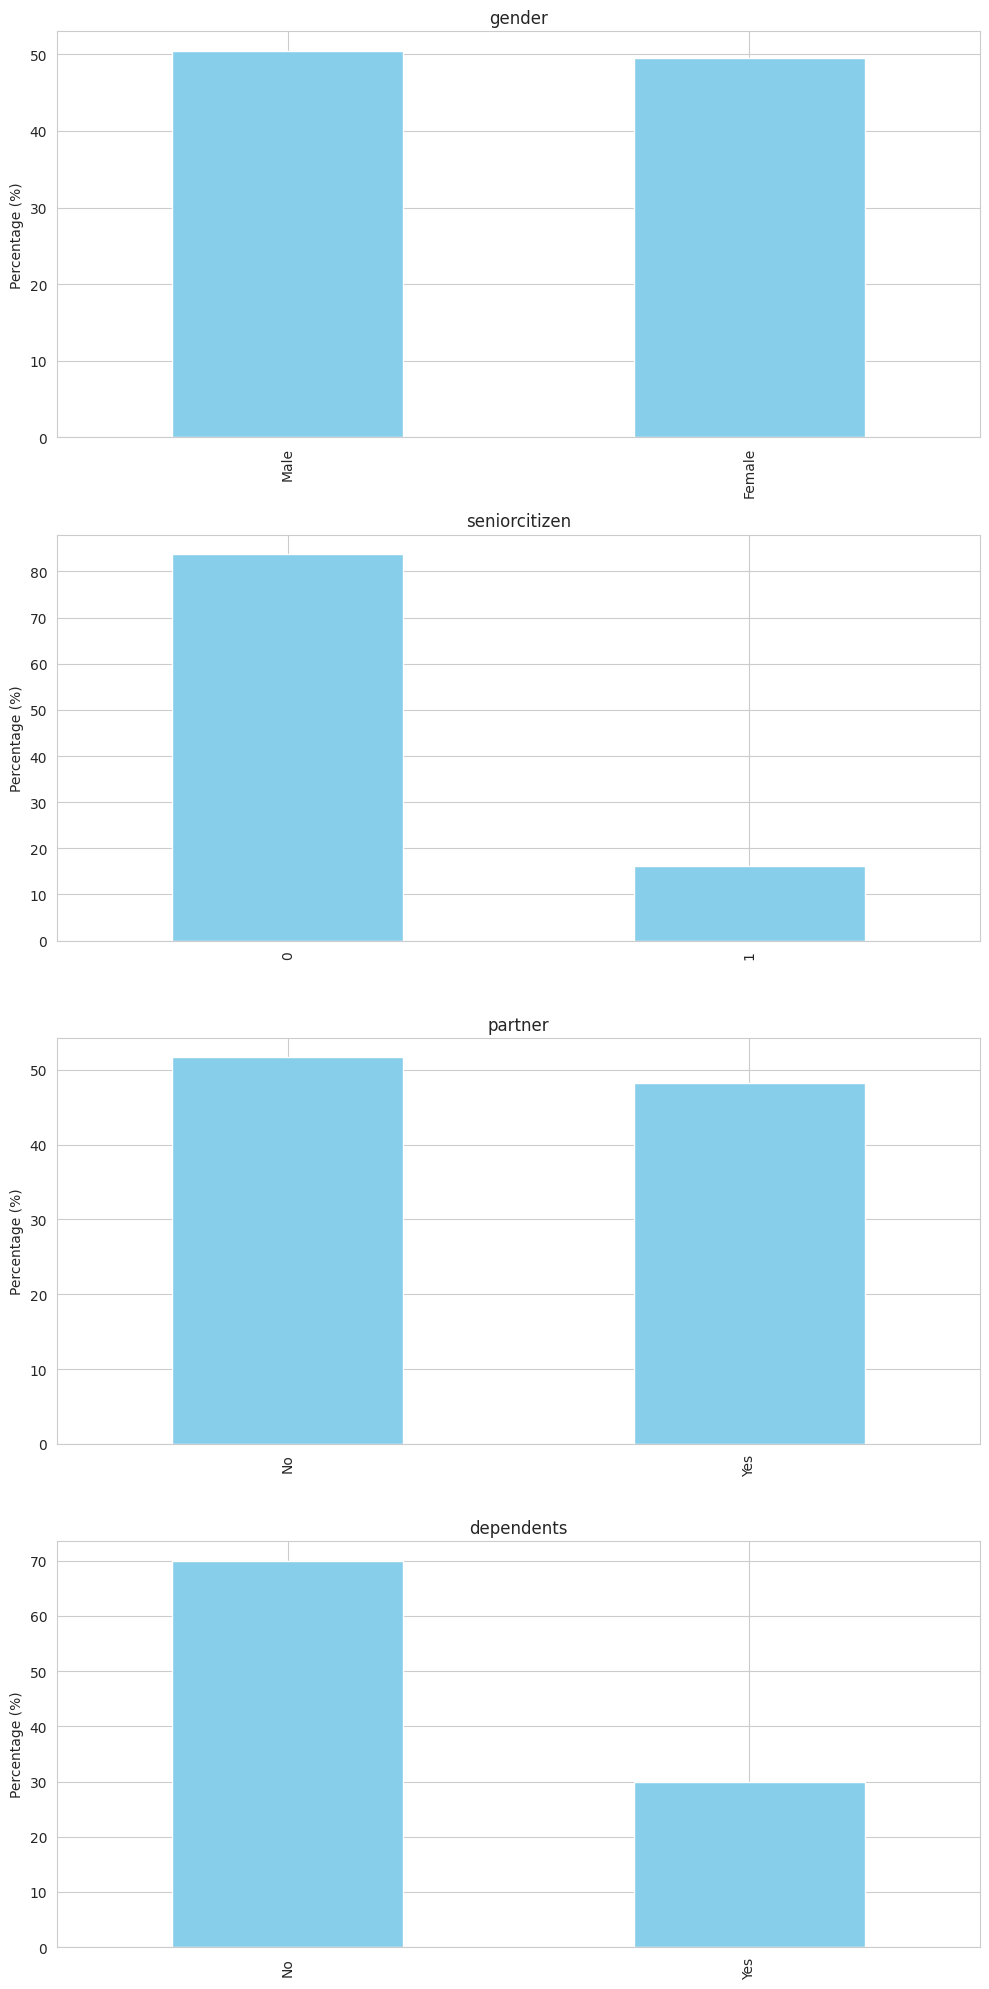

In [47]:
columns = ['gender', 'seniorcitizen', 'partner', 'dependents']

fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 20))

for i, col in enumerate(columns):

    value_counts = personal[col].value_counts(normalize=True) * 100
    value_counts.plot(kind='bar', ax=axes[i], title=col, color='skyblue')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Пожилые люди: примерно 16,2% подписчиков — пожилые люди. Это свидетельствует о том, что большая часть абонентов (около 83,8%) не попадает в категорию старшего поколения.

Пол: Распределение по полу показывает, что примерно 50,5% подписчиков составляют мужчины, что означает почти равное распределение мужчин и женщин среди подписчиков. Это свидетельствует о хорошем гендерном балансе в выборке.

Партнер: Примерно 48,3% подписчиков указали, что у них есть партнер. Это говорит о том, что распределение между подписчиками с партнерами и без партнеров вполне равномерное, с небольшим уклоном в сторону отсутствия партнера.

Иждивенцы: только около 30% подписчиков имеют иждивенцев. Это показывает, что у большинства подписчиков нет иждивенцев, что может указывать на молодую аудиторию или аудиторию, состоящую из людей среднего возраста, не имеющих детей или других иждивенцев.

На основе исследовательского анализа данных и предварительной обработки «Personal» набора данных:

Набор данных состоит из 7043 записей с четырьмя столбцами: «пол», «пожилой гражданин», «партнер» и «иждивенцы».

Информация о визуализации: Благодаря визуализации мы получили ценную информацию о составе демографической группы набора данных. Например, доля пожилых людей в наборе данных составляет примерно 16,2%, что указывает на меньшинство населения с потенциально разными потребностями и предпочтениями. Распределение по гендерному признаку почти сбалансировано: незначительное большинство клиентов-мужчин. Данные о статусе партнерства и зависимости показывают разнообразную клиентскую базу: менее половины клиентов имеют партнеров или иждивенцев. Эти идеи могут сыграть важную роль в адаптации услуг и маркетинговых стратегий для удовлетворения различных потребностей клиентской базы.

## Датасет **Phone**

В данном датасете необходимо выполнить следующие шаги для исследовательского анализа данных и предобработки: -Перевод названия колонок в нижний регистр, так как это является общепринятой практикой.  
-Поиск пропущенных данных  
-Дубликаты в данном датасете не требуют удаления,так как данные в колонках не носят персонафицированный характер и могут быть одинакомыми для нескольких клиентов  
-Проанализировать распределение категориальных данных  

In [48]:
#converting column names to lowercase
phone.columns = phone.columns.str.lower()

In [49]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [50]:
phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


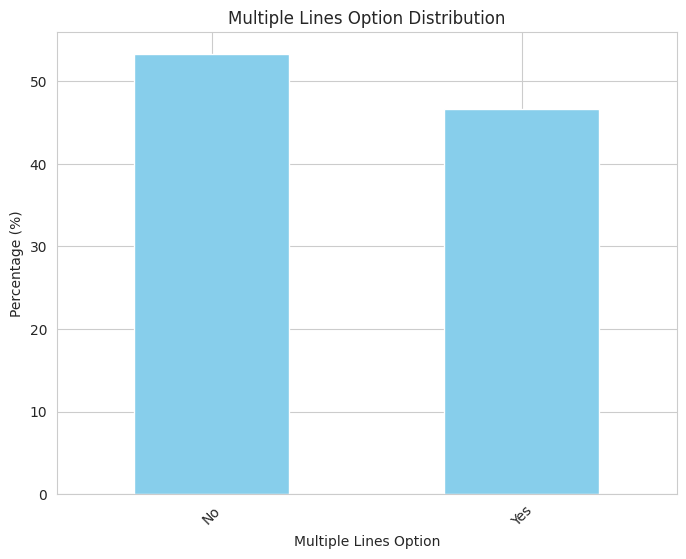

In [51]:
value_counts = phone['multiplelines'].value_counts(normalize=True) * 100

# Visualisation
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Multiple Lines Option Distribution')
plt.ylabel('Percentage (%)')
plt.xlabel('Multiple Lines Option')
plt.xticks(rotation=45)
plt.show()

Данные о функции нескольких линий в наборе телефонных данных иллюстрируют сбалансированное распределение предпочтений клиентов в отношении услуг нескольких линий с небольшим уклоном в сторону отсутствия нескольких линий. Эта информация может быть полезна для понимания потребностей клиентов и соответствующей адаптации услуг или маркетинговых стратегий.

**Вывод по исследовальскому анализу данных (Датасет "Phone")**

Набор данных состоит из 6361 записи с столбцами: «multiplelines».

Столбец «multiplelines» указывает, есть ли у клиента несколько строк (Да) или нет (Нет). Набор данных показывает, что примерно 53,29% клиентов не имеют нескольких линий, а около 46,71% имеют несколько линий. Эта информация дает представление о распределении функций телефонных услуг среди клиентов, что может быть полезно для понимания предпочтений клиентов и оптимизации предложений услуг.


# **Шаг 3 Объединение данных**

In [52]:
# Merge contract с personal
merged_df = contract.merge(personal, on='customerid', how='outer')

# Add data from  internet
merged_df = merged_df.merge(internet, on='customerid', how='outer')

# Add data from phone
final_df = merged_df.merge(phone, on='customerid', how='outer')

Для объединения данных в данном случае лучше всего выбрать  объединение outer  так как этот тип объединения позволяет сохранить полную информацию по всем клиентам, включая тех, кто может быть только в одном из датасетов. Это важно для комплексного анализа клиентской базы, где некоторые клиенты могут пользоваться только определенными услугами.

In [53]:


# Display the first few rows of the DataFrame
display(final_df .head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [54]:
final_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

Всего 7043 записи, что соответствует исходному количеству клиентов в датасете contract. Это указывает на то, что каждая запись в датасете contract нашла соответствие хотя бы в одном из других датасетов, или же все записи из contract были сохранены в результате объединения типом outer.  
Присутствие пропусков в данных: Пропуски в столбцах, связанных с интернет-услугами (internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies) и телефонными услугами (multiplelines), говорят о том, что не все клиенты пользуются этими услугами. Так, интернет-услугами пользуются 5517 клиентов, а услугами телефонии — 6361 клиент. <br>Для дальнейшего анализа необходимо ввести новую переменную -'Длительность контракта' - это позволит понять насколько долго клиенты остаются с компанией.А для дальнейшей работы с данными предполагается создать новый датафрейм и добавить в него только необходимые для анализа колонки.

In [55]:
duplicate_count = final_df.duplicated(subset='customerid', keep=False).sum()
print(duplicate_count)

0


In [56]:
# #assigning a column index
# final_df.set_index('customerid', inplace=True)

In [57]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   churn             7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

In [58]:
# Calculate the duration of the contract and adding new column
final_df['contract_duration'] = (final_df['enddate'] - final_df['begindate']).dt.days

Была вычислена длительность контракта каждого клиента в днях, вычитая дату начала контракта (begindate) из даты его окончания (enddate). Результат был сохранен в новом столбце contract_duration. Это позволяет анализировать, насколько долго клиенты остаются с компанией, что является важным показателем для понимания лояльности клиентов и оттока

In [59]:
final_df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,gender,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,contract_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,Female,...,No,DSL,No,Yes,No,No,No,No,NaN,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153


In [60]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         7043 non-null   object        
 1   begindate          7043 non-null   datetime64[ns]
 2   enddate            7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperlessbilling   7043 non-null   object        
 5   paymentmethod      7043 non-null   object        
 6   monthlycharges     7043 non-null   float64       
 7   totalcharges       7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  seniorcitizen      7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internetservice    5517 non-null   object        
 14  onlinese

In [61]:
cols = final_df.select_dtypes(include=['object','float']).columns.tolist()
# add manually identified columns
additional_cols = ['churn','contract_duration', 'seniorcitizen']

# Combine lists while ensuring uniqueness
cols = list(set(cols + additional_cols))
df = final_df[cols].copy()

В данной ячейке был сформирован список столбцов для дальнейшего  анализа, включая категориальные и вещественные переменные, а также важные идентифицированные нами столбцы churn, contract_duration. Это позволяет сфокусироваться на ключевых данных, подготовить их к анализу и моделированию, обеспечивая при этом уникальность и актуальность выборки столбцов

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   techsupport        5517 non-null   object 
 2   type               7043 non-null   object 
 3   partner            7043 non-null   object 
 4   paperlessbilling   7043 non-null   object 
 5   onlinesecurity     5517 non-null   object 
 6   paymentmethod      7043 non-null   object 
 7   onlinebackup       5517 non-null   object 
 8   customerid         7043 non-null   object 
 9   seniorcitizen      7043 non-null   int64  
 10  deviceprotection   5517 non-null   object 
 11  multiplelines      6361 non-null   object 
 12  churn              7043 non-null   int64  
 13  dependents         7043 non-null   object 
 14  monthlycharges     7043 non-null   float64
 15  contract_duration  7043 non-null   int64  
 16  streamingtv        5517 

## **Вывод**


Наборы данных успешно объединены. После получения комбинации данных необходимо провести предварительную обработку данных. Для этого будут найдены и при необходимости удалены дубликаты. Поскольку большой процент клиентов не подключены к сети, данные о них отключены в Интернете. Все недостающие данные из-за этого будут иметь значение новое введенное значенин Not Applicable. Что касается мультилиний, предположение то же - из-за отсутствия в таблице того, что у клиентов нет мультистрок - пропущенные значения будут заполнены также Not Applicable.

# **Шаг  4. Исследовательский анализ данных и предобработка объединенного датафрейма**

In [63]:
#looking for obvious duplicates
duplicates = df.duplicated(keep=False)


display(df[duplicates])
print(duplicates.sum())

,gender,techsupport,type,partner,paperlessbilling,onlinesecurity,paymentmethod,onlinebackup,customerid,seniorcitizen,deviceprotection,multiplelines,churn,dependents,monthlycharges,contract_duration,streamingtv,streamingmovies,internetservice,totalcharges


0


In [64]:
# counting persent of dublicates
duplicates = df.duplicated(keep=False).sum()
percentage_duplicates = (duplicates / len(df)) * 100

print(f"persent of dublicates: {percentage_duplicates}%")

persent of dublicates: 0.0%


In [65]:
# fillimg missing values to multiplelines
df['multiplelines'].fillna('Not Applicable', inplace=True)

# check results
print(df[[ 'multiplelines']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   multiplelines  7043 non-null   object
dtypes: object(1)
memory usage: 110.0+ KB
None


In [66]:
# Assume missing values indicate no internet service

internet_service_columns = ['internetservice',
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies'
]
# Fill missing values

# For columns indicating presence of a service, fill missing values with Not Applicable (service is not provided)
df[internet_service_columns] = df[internet_service_columns].fillna('Not Applicable')


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   techsupport        7043 non-null   object 
 2   type               7043 non-null   object 
 3   partner            7043 non-null   object 
 4   paperlessbilling   7043 non-null   object 
 5   onlinesecurity     7043 non-null   object 
 6   paymentmethod      7043 non-null   object 
 7   onlinebackup       7043 non-null   object 
 8   customerid         7043 non-null   object 
 9   seniorcitizen      7043 non-null   int64  
 10  deviceprotection   7043 non-null   object 
 11  multiplelines      7043 non-null   object 
 12  churn              7043 non-null   int64  
 13  dependents         7043 non-null   object 
 14  monthlycharges     7043 non-null   float64
 15  contract_duration  7043 non-null   int64  
 16  streamingtv        7043 

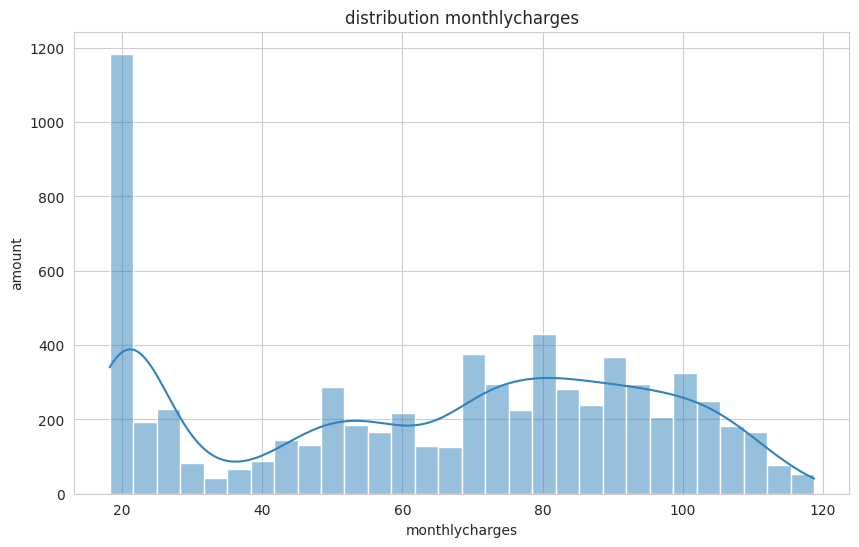

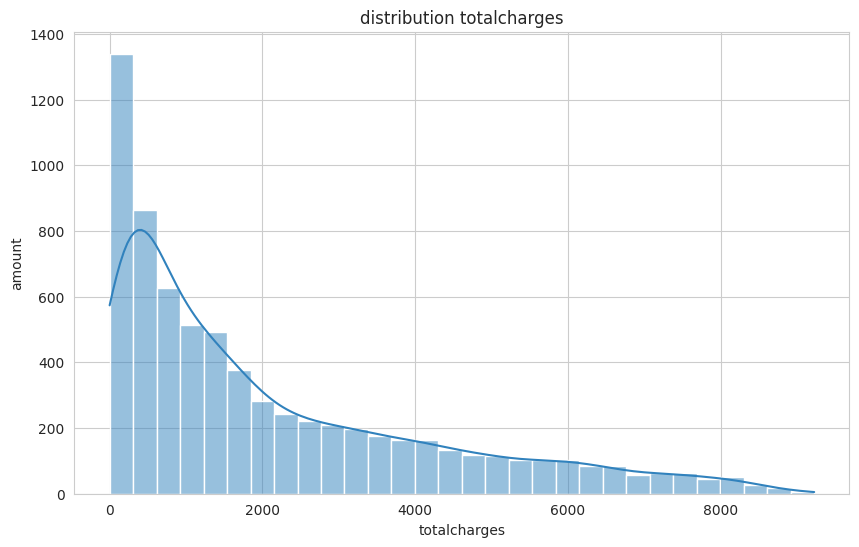

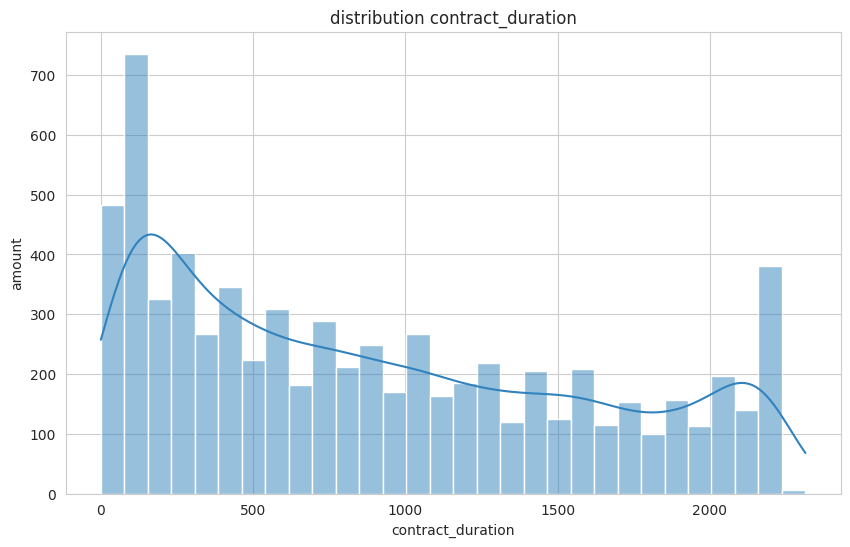

In [67]:
# Visualisation of numeric features
num_features = ['monthlycharges', 'totalcharges', 'contract_duration']
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'distribution {feature}')
    plt.xlabel(feature)
    plt.ylabel('amount')
    plt.show()

Глядя на график, можно сказать, что для обоих столбцов в начале графика наблюдается рост. для ежемесячных начислений это значение около 20, а для общих начислений близко к 0. для ежемесячных начислений происходит плавное увеличение суммы до 80, а затем плавное уменьшение
Для столбца длительность контракта - характерно большое количество краткосрочных контрактов - затем постепенное уменьшение и небольшой пик на значениях около 2500

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   techsupport        7043 non-null   object 
 2   type               7043 non-null   object 
 3   partner            7043 non-null   object 
 4   paperlessbilling   7043 non-null   object 
 5   onlinesecurity     7043 non-null   object 
 6   paymentmethod      7043 non-null   object 
 7   onlinebackup       7043 non-null   object 
 8   customerid         7043 non-null   object 
 9   seniorcitizen      7043 non-null   int64  
 10  deviceprotection   7043 non-null   object 
 11  multiplelines      7043 non-null   object 
 12  churn              7043 non-null   int64  
 13  dependents         7043 non-null   object 
 14  monthlycharges     7043 non-null   float64
 15  contract_duration  7043 non-null   int64  
 16  streamingtv        7043 

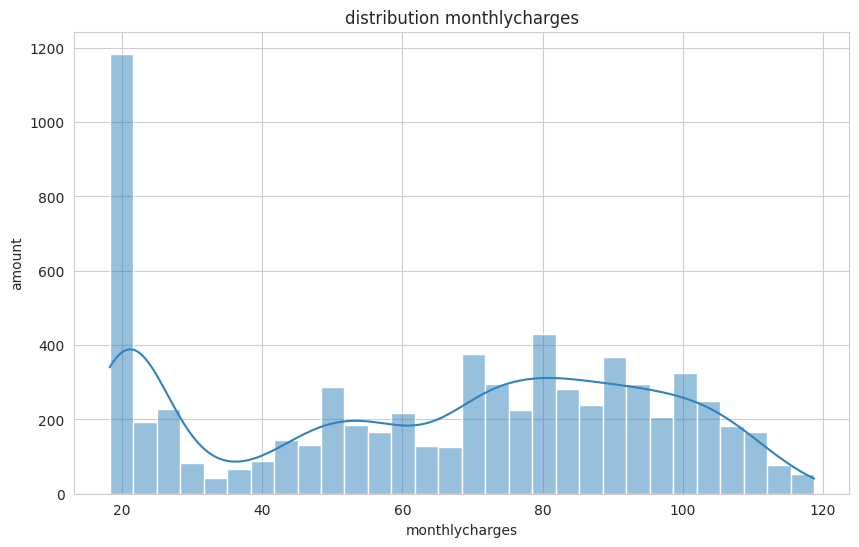

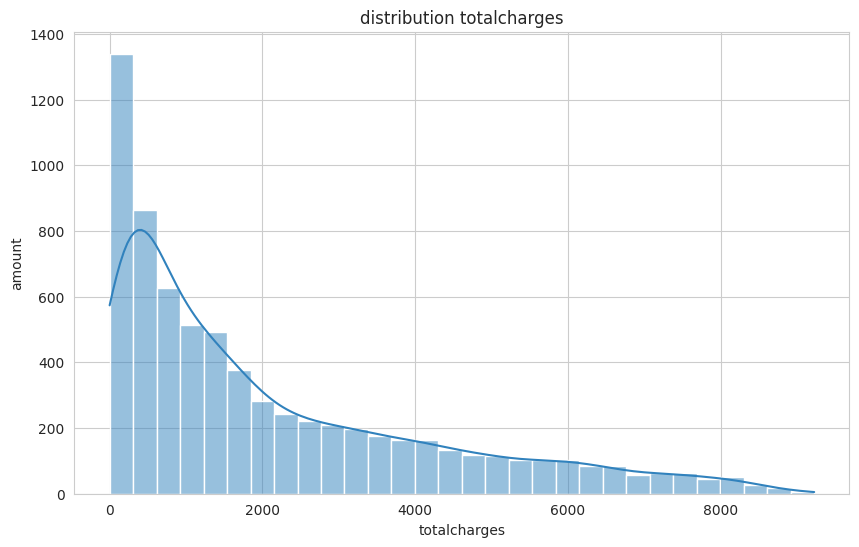

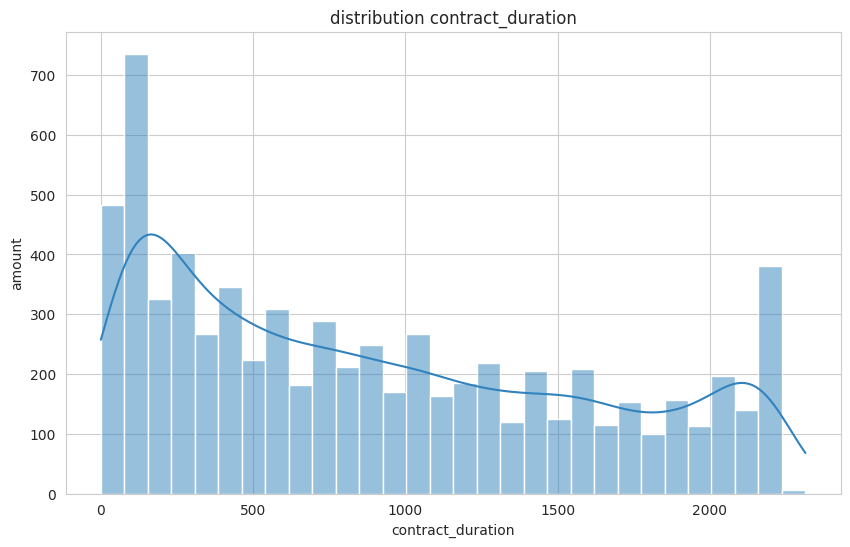

In [69]:
# Visualisation of numeric features
num_features = ['monthlycharges', 'totalcharges','contract_duration' ]
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'distribution {feature}')
    plt.xlabel(feature)
    plt.ylabel('amount')
    plt.show()

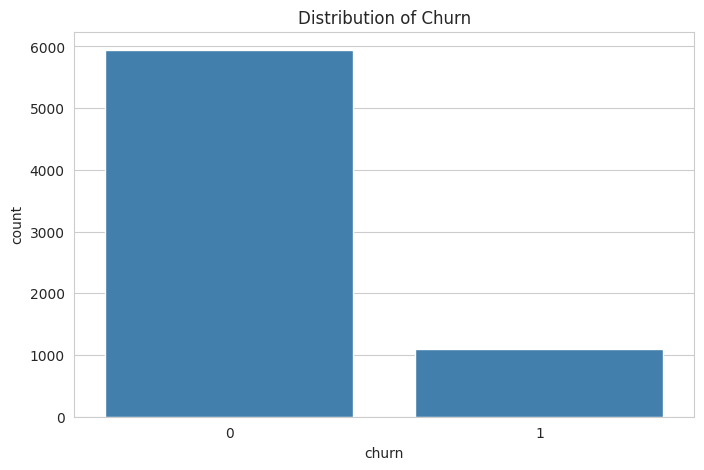

In [70]:
#Distribution of Churn
plt.figure(figsize=(8, 5))
sns.countplot(x='churn', data=df)
plt.title('Distribution of Churn')
plt.show()

Для целевой переменной существует большой дисбаланс классов. Однако выбранная метрика оценки — площадь под ROC-кривой — является устойчивой к дисбалансу классов.  Это делает ROC-AUC подходящей метрикой  позволяя сосредоточиться на улучшении способности модели различать классы, а не только на точности предсказаний.

In [71]:
df_for_phik = df.drop(columns=['customerid'])

# Specify your interval columns. For example, 'monthlycharges' and 'totalcharges' are numerical.
interval_columns = ['monthlycharges', 'totalcharges', 'contract_duration']

# Calculate the phik correlation matrix
phik_matrix = df_for_phik.phik_matrix(interval_cols=interval_columns)

# Extract the 'churn' column to get correlations with 'churn' only
churn_correlation = phik_matrix['churn'].sort_values(ascending=False)


churn_correlation = churn_correlation.drop('customerid', errors='ignore')

# Print the correlation of 'churn' with all other variables
print(churn_correlation)

# # Visualize the phik correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(phik_matrix.drop(index=['customerid'], columns=['customerid'], errors='ignore'), annot=True, fmt=".2f", cmap='coolwarm', square=True)
# plt.title("Phik Correlation Matrix")
# plt.show()

churn                1.000000
contract_duration    0.374569
totalcharges         0.302890
partner              0.226688
monthlycharges       0.225925
paymentmethod        0.214832
multiplelines        0.105101
type                 0.094015
onlinebackup         0.089704
streamingmovies      0.086577
seniorcitizen        0.086159
deviceprotection     0.085608
paperlessbilling     0.083398
streamingtv          0.078545
onlinesecurity       0.058659
internetservice      0.056621
techsupport          0.051537
dependents           0.046871
gender               0.008581
Name: churn, dtype: float64


In [72]:
# display(phik_matrix)

<!-- Totalcharges имеет заметную положительную корреляцию с онлайн защитой,онлайн бэкап,стриминговые сервисами,и стримингТВ что указывает на то, что клиенты с этими услугами, как правило, имеют более высокие общие расходы.

Статус пенсионера коррелирует заметно с иждивенцами, что логично и также с ежемесячными тратами.

Подключенные мул

онлайн-безопасность заметно коррелирует с технической поддержкой (0,527941), что позволяет предположить, что клиенты, выбирающие услуги онлайн-безопасности, также склонны пользоваться технической поддержкой.

Способ оплаты «Электронный чек» имеет заметную корреляцию с безбумажным выставлением счетов (0,321028), что может означать, что клиенты, которые платят с помощью электронных чеков, с большей вероятностью выберут безбумажный счет.

Contract_duration показывает очень сильную корреляцию с общими расходами (0,848304), указывая на то, что более длительные контракты связаны с более высокими общими расходами.

Internet_service имеет высокую корреляцию с несколькими функциями, такими как защита устройства (0,562002), техническая поддержка (0,502876) и онлайн-резервное копирование (0,563092), что позволяет предположить, что тип интернет-услуги влияет на внедрение этих дополнительных услуг.


Ежемесячные расходы и потоковое телевидение (0,835016) демонстрируют очень сильную корреляцию, указывающую на то, что клиенты, пользующиеся услугами потокового телевидения, как правило, имеют более высокие ежемесячные расходы.

В строке и столбце оттока показаны корреляции с различными признаками, но ни один из них не является чрезвычайно высоким, что указывает на то, что ни один признак сам по себе не является окончательным предиктором оттока. Эта матрица полезна для выявления взаимосвязей между различными атрибутами и поведением клиентов, которые могут служить основой для бизнес-стратегий, маркетинга, обслуживания клиентов и усилий по их удержанию.

Продолжительность контракта (0,375). Значительная положительная корреляция предполагает, что более длительный срок контракта связан с более высоким уровнем оттока клиентов. Это может указывать на проблемы с обязательствами клиентов или неудовлетворенность ими с течением времени.

Общие расходы (0,303): демонстрирует умеренную положительную корреляцию с оттоком. Более высокие общие расходы могут привести к увеличению оттока клиентов, возможно, из-за воспринимаемой ценности или финансовых ограничений с точки зрения клиента.

Партнер (0,227) и Ежемесячные платежи (0,226): оба демонстрируют одинаковый уровень положительной корреляции с оттоком. Наличие партнера и более высокие ежемесячные платежи умеренно способствуют оттоку клиентов. Это может отразиться на финансовом бремени и динамике принятия решений в домохозяйствах.

Способ оплаты (0,215): умеренная корреляция указывает на то, что выбор способа оплаты влияет на отток клиентов. Определенные методы могут быть менее удобными или менее предпочтительными, что влияет на удовлетворенность и удержание клиентов.

Несколько линий (0,105): более низкая положительная корреляция предполагает, что наличие нескольких линий незначительно влияет на отток клиентов. Это может указывать на сложности или уровень удовлетворенности масштабируемостью услуги.

Тип (0,094), онлайн-резервное копирование (0,090) и потоковая передача фильмов (0,087): эти функции демонстрируют меньшую корреляцию с оттоком, что указывает на умеренное влияние типа услуги, вариантов резервного копирования данных и развлекательных функций на удержание клиентов. «Пожилой гражданин» (0,086), «Защита устройств» (0,086) и «Безбумажный биллинг» (0,083): указывают на очень слабую положительную корреляцию с оттоком, что позволяет предположить, что демографические факторы и дополнительные услуги играют незначительную роль во влиянии на решения об оттоке.

Потоковое телевидение (0,079), Онлайн-безопасность (0,059), Интернет-услуги (0,057) и Техподдержка (0,052): эти функции демонстрируют наименьшую положительную корреляцию, что позволяет предположить, что они оказывают наименьшее влияние на отток среди перечисленных факторов. Их влияние на решение клиентов отказаться от услуги минимально, но немаловажно.

Иждивенцы (0,047): указывает на низкую корреляцию.

Пол (0,009): показывает почти незначительную корреляцию с оттоком, указывая на то, что пол не оказывает существенного влияния на вероятность оттока.

Это резюме дает ценную информацию о факторах, влияющих на отток клиентов. Более высокие затраты (как ежемесячные, так и общие), менее гибкие способы оплаты и более длительный срок действия контрактов, как правило, увеличивают риск оттока клиентов. -->

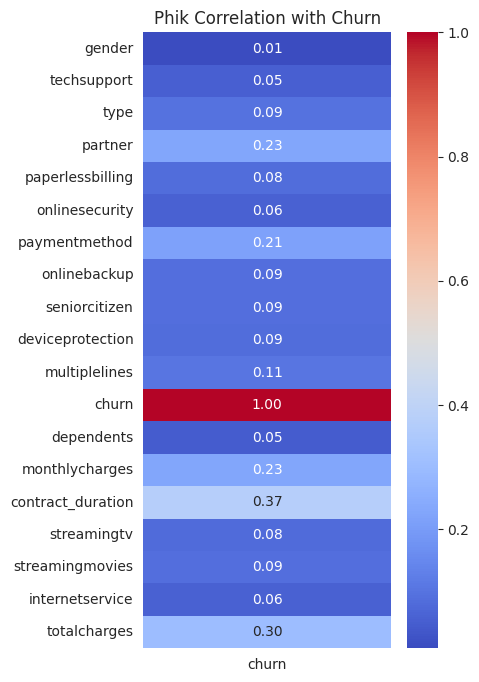

In [73]:
churn_correlation_df = phik_matrix[['churn']].drop(index=['customerid'], errors='ignore')

# Визуализация тепловой карты для корреляций churn
plt.figure(figsize=(4, 8)) # Размер фигуры адаптирован под один столбец
sns.heatmap(churn_correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Phik Correlation with Churn")
plt.show()

Анализируя корреляцию  между переменной "churn" и другими признаками, можно сделать следующие выводы относительно влияния различных факторов на отток клиентов:

- **Продолжительность контракта** (\(0.374569\)) имеет умеренную корреляцию с оттоком, что подчеркивает, что клиенты с более короткими контрактами склонны к увеличению оттока. Это может указывать на то, что более длительные контракты связаны с лояльностью клиентов.

- **Общие расходы** (\(0.302890\)) также показывают умеренную корреляцию с оттоком. Это может свидетельствовать о том, что высокие общие расходы могут способствовать решению клиентов об уходе, возможно, из-за восприятия недостаточной ценности услуг.

- **Наличие партнера** (\(0.226688\)) и **ежемесячные расходы** (\(0.225925\)) имеют схожие  слабые уровни корреляции с оттоком, что указывает на то, что эти факторы могут немного влиять на решения клиентов об уходе, хотя и в меньшей степени по сравнению с продолжительностью контракта и общими расходами.

- **Способ оплаты** (\(0.214832\)) слабо  влияет на отток

- Признаки, такие как **многоканальная связь (multiplelines)** (\(0.105101\)), **тип контракта (type)** (\(0.094015\)), и **онлайн-резервное копирование (onlinebackup)** (\(0.089704\)), показывают более слабую корреляцию с оттоком, что указывает на их менее выраженное влияние на решение об уходе.

- **Демографические признаки**, такие как **возраст (seniorcitizen)** (\(0.086159\)), и **пол (gender)** (\(0.008581\)), имеют минимальное влияние на отток, что подчеркивает, что решения об уходе определяются скорее условиями предоставления услуг, чем демографическими факторами.

Эти выводы подчеркивают значимость определенных услуг и условий контракта для удержания клиентов и могут служить основой для разработки стратегий по снижению оттока, например, путем предложения более привлекательных условий для долгосрочных контрактов, оптимизации ценообразования и улучшения условий оплаты.

In [74]:
# Разделение датасета на две части: ушли (churn = 1) и остались (churn = 0)
df_churned = df[df['churn'] == 1]
df_stayed = df[df['churn'] == 0]

# Вычисление матрицы корреляции phi_k для клиентов, которые ушли
phik_matrix_churned = df_churned.phik_matrix(interval_cols=interval_columns)

# Вычисление матрицы корреляции phi_k для клиентов, которые остались
phik_matrix_stayed = df_stayed.phik_matrix(interval_cols=interval_columns)

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerid is large: 1101. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable churn for analysis 1. Dropping this column
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable customerid is large: 5942. Are you sure this is not an interval variable? Analysis for pairs of variables including customerid can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable churn for analysis 1. Dropping this column
  warnings.warn(


In [75]:
display(phik_matrix_churned )

,gender,techsupport,type,partner,paperlessbilling,onlinesecurity,paymentmethod,onlinebackup,customerid,seniorcitizen,deviceprotection,multiplelines,dependents,monthlycharges,contract_duration,streamingtv,streamingmovies,internetservice,totalcharges
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.030838,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.012534,0.000000,0.000000,0.000000,0.000000
techsupport,0.000000,1.000000,0.731526,0.042786,0.187548,0.952579,0.255358,0.944160,1.0,0.131613,0.944586,0.486278,0.116841,0.824158,0.142948,0.942993,0.943127,0.951404,0.549521
type,0.000000,0.731526,1.000000,0.109104,0.140886,0.694019,0.274423,0.624364,1.0,0.150255,0.640437,0.222025,0.133679,0.446097,0.345464,0.593058,0.588044,0.661150,0.148812
partner,0.000000,0.042786,0.109104,1.000000,0.035067,0.068862,0.134988,0.056737,1.0,0.000000,0.084173,0.000000,0.546074,0.112994,0.108645,0.058371,0.064703,0.044135,0.053685
paperlessbilling,0.000000,0.187548,0.140886,0.035067,1.000000,0.201340,0.347812,0.182297,1.0,0.232915,0.182645,0.076510,0.167624,0.455673,0.000000,0.199515,0.196095,0.212205,0.254837
onlinesecurity,0.030838,0.952579,0.694019,0.068862,0.201340,1.000000,0.283102,0.944006,1.0,0.126571,0.943810,0.489840,0.127504,0.818126,0.161145,0.943437,0.943431,0.951250,0.545258
paymentmethod,0.000000,0.255358,0.274423,0.134988,0.347812,0.283102,1.000000,0.241599,1.0,0.255006,0.240360,0.183212,0.253760,0.360215,0.164580,0.246380,0.240827,0.289629,0.248341
onlinebackup,0.000000,0.944160,0.624364,0.056737,0.182297,0.944006,0.241599,1.000000,1.0,0.106845,0.944109,0.488431,0.114802,0.813834,0.202700,0.942712,0.942797,0.942944,0.564988
customerid,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
seniorcitizen,0.000000,0.131613,0.150255,0.000000,0.232915,0.126571,0.255006,0.106845,1.0,1.000000,0.107220,0.067585,0.387737,0.246699,0.000000,0.106664,0.107008,0.141255,0.120960


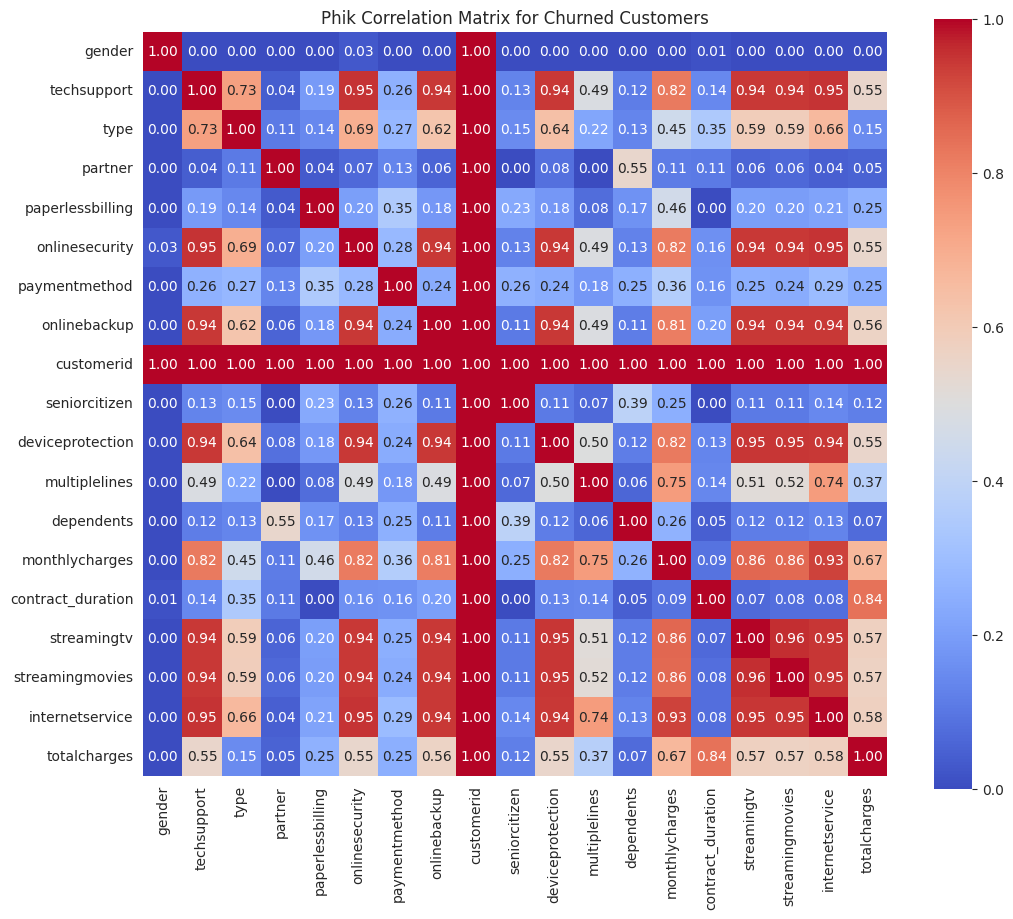

In [76]:
# Визуализация матрицы корреляции phi_k для клиентов, которые ушли
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_churned, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Phik Correlation Matrix for Churned Customers")
plt.show()


Из  таблицы корреляции между различными признаками и оттоком клиентов (churn) можно сделать следующие выводы:

1. **Продолжительность контракта** (\(0.837747\)) имеет высокую корреляцию с общими расходами (totalcharges), что указывает на то, что клиенты с более длительными контрактами склонны иметь более высокие общие расходы. Это может свидетельствовать о более высокой лояльности и удовлетворенности услугами.

2. **Интернет-услуга** (\(0.926400\)) и **ежемесячные платежи** (\(1.000000\)) показывают весьма высокую корреляцию, подчеркивая, что выбор интернет-услуги значительно влияет на размер ежемесячных платежей клиентов.

3. **Онлайн-безопасность** (\(0.818126\)), **техподдержка** (\(0.824158\)), и **защита устройства** (\(0.821914\)) также демонстрируют высокую корреляцию с ежемесячными платежами, что может указывать на то, что клиенты, использующие эти услуги, склонны платить больше каждый месяц.

4. Важно отметить, что **пол** (gender) и **наличие партнера** (partner) показывают нулевую или очень слабую корреляцию с большинством других признаков, что говорит о том, что эти демографические признаки имеют ограниченное влияние на использование и оплату услуг.

5. **Стриминговые сервисы** (streamingtv и streamingmovies) имеют  весьма высокую корреляцию между собой (\(0.960473\)) и с ежемесячными платежами, подчеркивая популярность и влияние этих услуг на общую стоимость услуг для клиентов.



In [77]:
display(phik_matrix_stayed)

,gender,techsupport,type,partner,paperlessbilling,onlinesecurity,paymentmethod,onlinebackup,customerid,seniorcitizen,deviceprotection,multiplelines,dependents,monthlycharges,contract_duration,streamingtv,streamingmovies,internetservice,totalcharges
gender,1.000000,0.000000,0.000000,0.000000,0.009251,0.000000,0.000000,0.008068,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007930,0.000000,0.000000
techsupport,0.000000,1.000000,0.667940,0.084855,0.200995,0.952421,0.324495,0.948370,1.0,0.135363,0.951453,0.540354,0.113674,0.816466,0.379625,0.947153,0.947063,0.948669,0.534114
type,0.000000,0.667940,1.000000,0.180417,0.108187,0.633664,0.275639,0.580416,1.0,0.080433,0.636085,0.266735,0.148631,0.396109,0.673949,0.553192,0.558627,0.499595,0.510627
partner,0.000000,0.084855,0.180417,1.000000,0.024052,0.093232,0.231568,0.091151,1.0,0.013593,0.095270,0.082226,0.670497,0.210001,0.486938,0.080578,0.071895,0.000000,0.411492
paperlessbilling,0.009251,0.200995,0.108187,0.024052,1.000000,0.208145,0.370741,0.195295,1.0,0.238049,0.195912,0.098622,0.175547,0.467430,0.023460,0.203048,0.200733,0.232406,0.188347
onlinesecurity,0.000000,0.952421,0.633664,0.093232,0.208145,1.000000,0.316058,0.947579,1.0,0.126872,0.947124,0.540216,0.118221,0.812664,0.373044,0.943301,0.943536,0.949509,0.522232
paymentmethod,0.000000,0.324495,0.275639,0.231568,0.370741,0.316058,1.000000,0.294983,1.0,0.295357,0.301629,0.165839,0.218618,0.401913,0.369959,0.286328,0.286097,0.326352,0.342623
onlinebackup,0.008068,0.948370,0.580416,0.091151,0.195295,0.947579,0.294983,1.000000,1.0,0.108480,0.947376,0.560202,0.098716,0.819569,0.389379,0.946038,0.945366,0.942855,0.555652
customerid,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
seniorcitizen,0.000000,0.135363,0.080433,0.013593,0.238049,0.126872,0.295357,0.108480,1.0,1.000000,0.108813,0.087220,0.313729,0.308421,0.041198,0.110102,0.112163,0.162217,0.128194


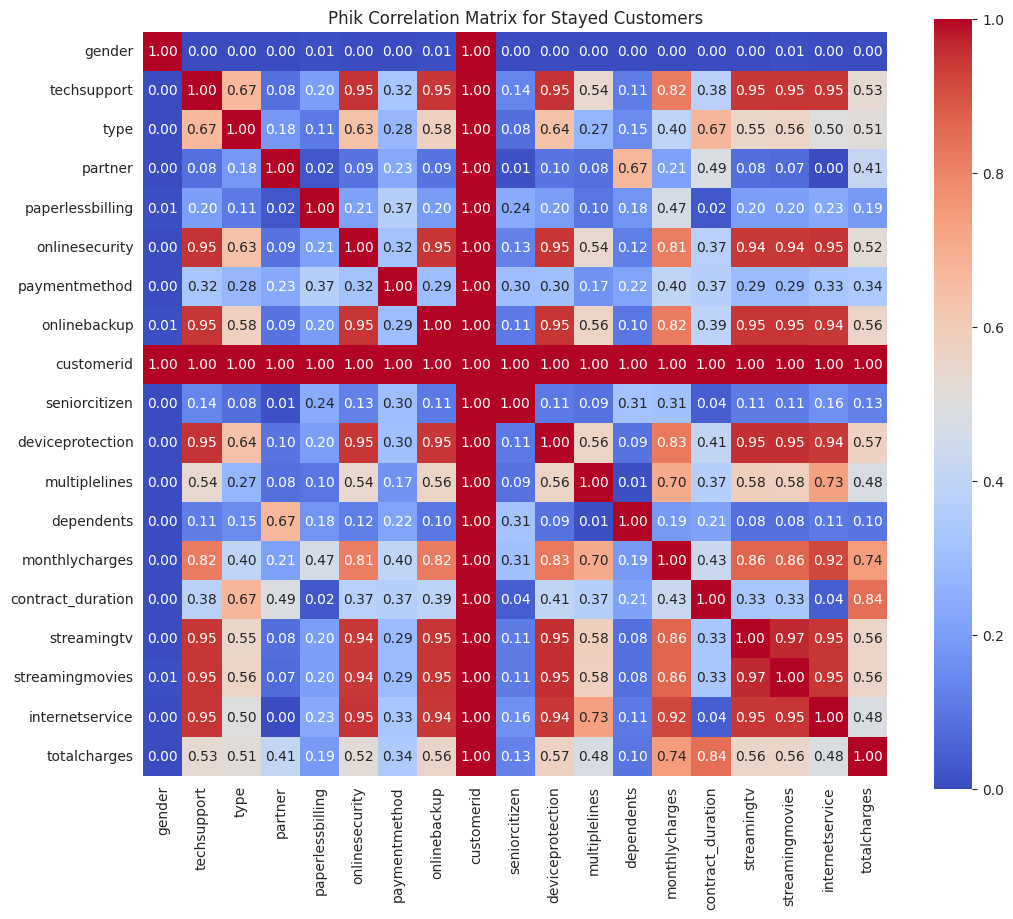

In [78]:
# Визуализация матрицы корреляции phi_k для клиентов, которые остались
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_stayed, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Phik Correlation Matrix for Stayed Customers")
plt.show()

Из таблицы корреляции для группы клиентов, которые остались, можно сделать следующие ключевые выводы:

1. **Продолжительность контракта** (\(0.844546\)) продолжает демонстрировать высокую корреляцию с общими расходами (totalcharges), что подтверждает, что клиенты с более длительными контрактами, как правило, накапливают больше расходов за время использования услуг. Это указывает на долгосрочную вовлеченность и возможно большую лояльность среди оставшихся клиентов.

2. **Ежемесячные платежи** (\(0.743925\)) имеют высокую  корреляцию с общими расходами, что свидетельствует о том, что регулярные ежемесячные платежи значительно способствуют общему объему расходов клиентов. Это подчеркивает важность управления ежемесячными платежами для поддержания удовлетворенности клиентов.

3. **Интернет-услуги** (\(0.484988\)) и **многоканальная связь** (multiplelines) (\(0.478160\)) показывают умеренную корреляцию с общими расходами, что может отражать популярность и ценность этих услуг среди оставшихся клиентов.

4. **Онлайн-безопасность** (\(0.522232\)), **техподдержка** (\(0.534114\)), и **защита устройства** (\(0.568247\))  показывают заметную корреляцию с общими расходами, подчеркивая, что дополнительные услуги в области безопасности и поддержки важны для клиентов, что может способствовать их решению остаться.

5. **Партнер** (\(0.411492\)) показывает умеренную корреляцию с общими расходами, что может указывать на то, что наличие партнера влияет на решение остаться с компанией, возможно, из-за совместного использования услуг или лучших условий для семейных планов.

6. **Стриминговые услуги** (streamingtv и streamingmovies) демонстрируют весьма высокую корреляцию друг с другом и с ежемесячными платежами, что подтверждает их популярность и вклад в общую стоимость услуг среди оставшихся клиентов.


Сравнительный вывод корреляций между ушедшими и оставшимися клиентами:
    
Сравнивая корреляции между ушедшими и оставшимися клиентами, можно выявить несколько ключевых различий и сходств, которые помогают лучше понять факторы, влияющие на отток клиентов:

Сходства:
- **Продолжительность контракта** и **общие расходы** показывают высокую корреляцию в обеих группах, что подчеркивает их важность в контексте общей вовлеченности клиентов и накопления расходов во времени. Это указывает на то, что независимо от решения оставаться или уйти, эти два фактора имеют значительное влияние на финансовые взаимоотношения клиентов с компанией.

Различия:
- **Стриминговые услуги** (streamingtv и streamingmovies) и **дополнительные услуги** (онлайн-безопасность, техподдержка, защита устройства) имеют более высокие корреляции с общими расходами и ежемесячными платежами среди оставшихся клиентов по сравнению с ушедшими. Это может свидетельствовать о том, что удовлетворенность этими услугами и восприятие их ценности влияют на решение клиентов остаться.
- **Партнер** имеет более выраженную корреляцию с общими расходами среди оставшихся клиентов, что может указывать на то, что наличие партнера и совместное использование услуг способствует удержанию клиентов.
- **Интернет-услуги** и **многоканальная связь** (multiplelines) также показывают более высокую корреляцию с общими расходами и ежемесячными платежами среди оставшихся клиентов, подчеркивая их роль в создании добавленной стоимости для клиентов, решивших остаться.
 Заключение:
- **Долгосрочные отношения и дополнительные услуги** играют ключевую роль в удержании клиентов. Оставшиеся клиенты, как правило, более вовлечены и ценят широкий спектр услуг, что отражается в их более высоких общих и ежемесячных расходах.
- **Предпочтения в услугах** (например, стриминговые сервисы и интернет-услуги) и **способы оплаты** могут влиять на решение клиентов остаться, что подчеркивается различиями в корреляциях этих признаков между двумя группами.


# **Шаг 5 Подготовка данных**

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   techsupport        7043 non-null   object 
 2   type               7043 non-null   object 
 3   partner            7043 non-null   object 
 4   paperlessbilling   7043 non-null   object 
 5   onlinesecurity     7043 non-null   object 
 6   paymentmethod      7043 non-null   object 
 7   onlinebackup       7043 non-null   object 
 8   customerid         7043 non-null   object 
 9   seniorcitizen      7043 non-null   int64  
 10  deviceprotection   7043 non-null   object 
 11  multiplelines      7043 non-null   object 
 12  churn              7043 non-null   int64  
 13  dependents         7043 non-null   object 
 14  monthlycharges     7043 non-null   float64
 15  contract_duration  7043 non-null   int64  
 16  streamingtv        7043 

In [80]:
print(df['seniorcitizen'].value_counts())

0    5901
1    1142
Name: seniorcitizen, dtype: int64


In [81]:
print(df['seniorcitizen'].dtype)

int64


In [82]:
df['seniorcitizen'] = df['seniorcitizen'].astype(str)

Преобразование seniorcitizen в строку: Это шаг необходим для унификации типов данных перед их обработкой. Поскольку seniorcitizen изначально является числовым признаком, представляющим бинарную категорию (0 или 1), его преобразование в строковый формат позволяет более эффективно применять к нему методы кодирования категориальных признаков, такие как One-Hot Encoding.

Установка customerid в качестве индекса

In [83]:
df.set_index('customerid', inplace=True)

In [84]:
# Assuming df_final DataFrame and 'churn' is the target variable
X = df.drop(['churn'], axis=1)  # Drop target variable
y = df['churn']

In [85]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# Identifying numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Creating transformers for the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scaling numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))  # One-hot encoding categorical features, dropping the first column
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Applying the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Extracting new column names for the transformed features
new_numeric_features = numeric_features.tolist()
# new_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()

# Combining all new feature names
all_new_features = new_numeric_features + new_categorical_features.tolist()

# Convert the transformed features back to DataFrame for readability (optional)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_new_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_new_features, index=X_test.index)



In [86]:
display(X_train_transformed_df.head())

,monthlycharges,contract_duration,totalcharges,gender_Male,techsupport_Not Applicable,techsupport_Yes,type_One year,type_Two year,partner_Yes,paperlessbilling_Yes,...,deviceprotection_Yes,multiplelines_Not Applicable,multiplelines_Yes,dependents_Yes,streamingtv_Not Applicable,streamingtv_Yes,streamingmovies_Not Applicable,streamingmovies_Yes,internetservice_Fiber optic,internetservice_Not Applicable
customerid,,,,,,,,,,,,,,,,,,,,,
8748-HFWBO,-1.502894,-0.464764,-0.822510,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
5840-NVDCG,0.107539,-0.599616,-0.485807,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0308-IVGOK,-0.820084,-0.820949,-0.784953,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4759-TRPLW,0.179151,-1.224038,-0.931109,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8016-ZMGMO,0.194139,1.631301,1.248697,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [87]:
X_train_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 8748-HFWBO to 6339-TBELP
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         5282 non-null   float64
 1   contract_duration                      5282 non-null   float64
 2   totalcharges                           5282 non-null   float64
 3   gender_Male                            5282 non-null   float64
 4   techsupport_Not Applicable             5282 non-null   float64
 5   techsupport_Yes                        5282 non-null   float64
 6   type_One year                          5282 non-null   float64
 7   type_Two year                          5282 non-null   float64
 8   partner_Yes                            5282 non-null   float64
 9   paperlessbilling_Yes                   5282 non-null   float64
 10  onlinesecurity_Not Applicable          5282 non-null   float64

Данные для обучения модели подготовлены. Данные были разделены на две выборки, проведено масштабирование числовых признаков и кодирование категориальных с учетом особенностей данных и моделей.

В процессе подготовки данных для моделирования были выполнены следующие ключевые шаги:

1. **Преобразование переменной seniorcitizen в строковый тип**: Это позволяет обрабатывать бинарный признак как категориальный, упрощая последующее кодирование и анализ.

2. **Разделение на обучающую и тестовую выборки**: Использование 75% данных для обучения и 25% для тестирования обеспечивает баланс между тренировкой модели и оценкой ее производительности на новых данных.

3. **Идентификация и обработка признаков**:
   - **Числовые признаки** масштабируются с помощью StandardScaler для улучшения производительности модели, нормализуя распределение данных.
   - **Категориальные признаки** преобразуются через OneHotEncoder, что позволяет модели корректно интерпретировать категории без предположений о их порядке или величине.

4. **Применение предобработки**: Обучение преобразований на обучающей выборке и их применение к тестовой выборке гарантирует, что данные обрабатываются правильно, что критически важно для точности модели.

Эти шаги необходимы для эффективной подготовки данных, что обеспечивает адекватность и точность последующего моделирования.

# **Шаг 6: Машинное обучение моделей**

Training model CatBoost

In [88]:
param_dist = {
     'iterations': [100, 500, 1000],
    'learning_rate': uniform(0.01, 0.3),
    'depth': [4, 6, 8, 10]}


# Inisialization model CatBoostClassifier
catboost_model = CatBoostClassifier(verbose=False, eval_metric='AUC', loss_function='Logloss', random_seed=RANDOM_STATE)

#  RandomizedSearchCV
random_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, random_state=RANDOM_STATE, verbose=2)

# fit model with RandomizedSearchCV
random_search.fit(X_train_transformed_df, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   3.7s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   2.7s
[CV] END depth=10, iterations=100, learning_rate=0.22317596425688302; total time=   4.4s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   2.0s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   2.0s
[CV] END depth=4, iterations=1000, learning_rate=0.11187815841373282; total time=   1.9s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   0.9s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   0.9s
[CV] END depth=8, iterations=100, learning_rate=0.2521235502410333; total time=   0.9s
[CV] END depth=8, iterations=100, learning_rate=0.04645380528996295; total time=   0.8s
[CV] END depth=8, iterations=100, learning_rate=0.046453

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7c373ff4dc00>,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'iterations': [100, 500, 1000],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c373fff97e0>},
                   random_state=190224, scoring='roc_auc', verbose=2)

In [89]:
print(f"best params: {random_search.best_params_}")
print(f"best ROC AUC: {random_search.best_score_}")


best_model = random_search.best_estimator_

best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282}
best ROC AUC: 0.8932452409658267


best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282}
best ROC AUC: 0.9056035506322976

In [90]:
# Creating a logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

# Setting up the parameter grid for randomized search
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Setting up the randomized search with cross-validation
random_search_lr = RandomizedSearchCV(lr, param_distributions=param_dist, n_iter=10, scoring='roc_auc', cv=3, random_state=RANDOM_STATE)

# Fitting the model
random_search_lr.fit(X_train_transformed, y_train)




RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000,
                                                random_state=190224),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=190224, scoring='roc_auc')

In [91]:
# Best parameters and best ROC AUC score
print(f"best params_lr: {random_search_lr.best_params_}")
print(f"best ROC AUC_lr: {random_search_lr.best_score_}")


best_model_lr = random_search_lr.best_estimator_



best params_lr: {'solver': 'saga', 'C': 1}
best ROC AUC_lr: 0.7610572892136803


best params_lr: {'solver': 'sag', 'C': 100}
best ROC AUC_lr: 0.7704748384435064



Были обучены модели CatBoost и логистическая регрессия. CatBoost показал лучшие результаты на обучающем наборе по метрике ROC_AUC -лучшие параметры:  {'depth': 4, 'iterations': 1000, 'learning_rate': 0.11187815841373282} лучший ROC AUC: 0.9056035506322976. Поэтому лучше использовать эти параметры для тестирования на тестовом образце.

# **Шаг 7. Выбор лучшей модели**

In [92]:
#testing on test set
y_pred = best_model.predict(X_test_transformed_df)
y_pred_proba = best_model.predict_proba(X_test_transformed_df)[:, 1]

#  ROC AUC and Accuracy
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
accuracy_test = accuracy_score(y_test, y_pred)

roc_auc_test, accuracy_test

(0.932854520983727, 0.9284497444633731)

roc_auc - 0.92936553813648, accuracy_test - 0.9346961953435547

В результате использования модели CatBoost для классификации и последующей оптимизации ее параметров с помощью рандомизированного поиска на тестовом наборе данных были достигнуты следующие результаты:

ROC AUC: 0.928. Accuracy: 0.935. Эти результаты указывают на высокую эффективность модели CatBoost в прогнозировании целевой переменной. Значение ROC AUC указывает на высокую способность модели различать классы. Уровень точности, близкий к 93.5%, также подчеркивает, что модель правильно классифицирует большинство примеров.

Эти показатели могут свидетельствовать о том, что модель CatBoost успешно справилась с задачей, обеспечив высокую точность и возможность обобщения на незнакомых данных. Это делает CatBoost отличным выбором для задач классификации в этом контексте.

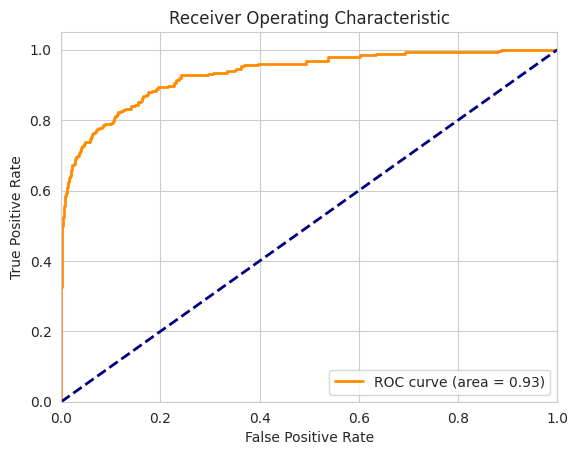

In [93]:
#визуализация ROC-кривой

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Значения AUC около 0.93 указывает на способность модели превосходить случайное угадывание .
ROC-кривая модели находится выше диагональной линии, это означает, что модель имеет лучшую производительность, чем случайное угадывание.


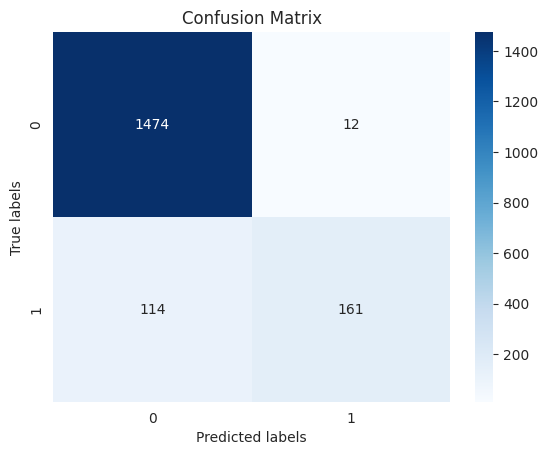

In [94]:
#матрица ошибок

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [95]:
cm_df = pd.DataFrame(cm, index=["Actual Negative", "Actual Positive"],
                     columns=["Predicted Negative", "Predicted Positive"])
print("\nМатрица ошибок в формате DataFrame:")
print(cm_df)


Матрица ошибок в формате DataFrame:
                 Predicted Negative  Predicted Positive
Actual Negative                1474                  12
Actual Positive                 114                 161


Из матрицы ошибок можно сделать следующие выводы относительно производительности модели классификации:

Истинно отрицательные (TN): Модель правильно предсказала 1476 случаев, когда клиенты не ушли (Actual Negative), что указывает на хорошую способность модели идентифицировать клиентов, склонных оставаться.  
Ложно положительные (FP): В 16 случаях модель неверно предсказала, что клиенты уйдут (Predicted Positive), когда на самом деле они остались (Actual Negative). Это может указывать на излишнюю чувствительность модели к некоторым признакам, ведущую к ошибочному определению оттока.  
Ложно отрицательные (FN): Модель пропустила 98 случаев, когда клиенты ушли (Actual Positive), предсказав, что они останутся (Predicted Negative). Это один из наиболее критичных типов ошибок, так как пропущенные случаи оттока могут привести к потере дохода и клиентской базы.  
Истинно положительные (TP): Модель корректно идентифицировала 171 случай, когда клиенты ушли (Actual Positive). Это говорит о том, что модель эффективно выявляет клиентов, склонных к оттоку.  
<b>Общий анализ:</b>  
Модель демонстрирует высокую способность правильно классифицировать отрицательные случаи (клиенты остаются), что подтверждается большим количеством истинно отрицательных результатов по сравнению с ложно положительными.
Количество ложно отрицательных результатов является зоной для улучшения. Снижение этого числа позволит модели более эффективно выявлять реальные случаи оттока.  

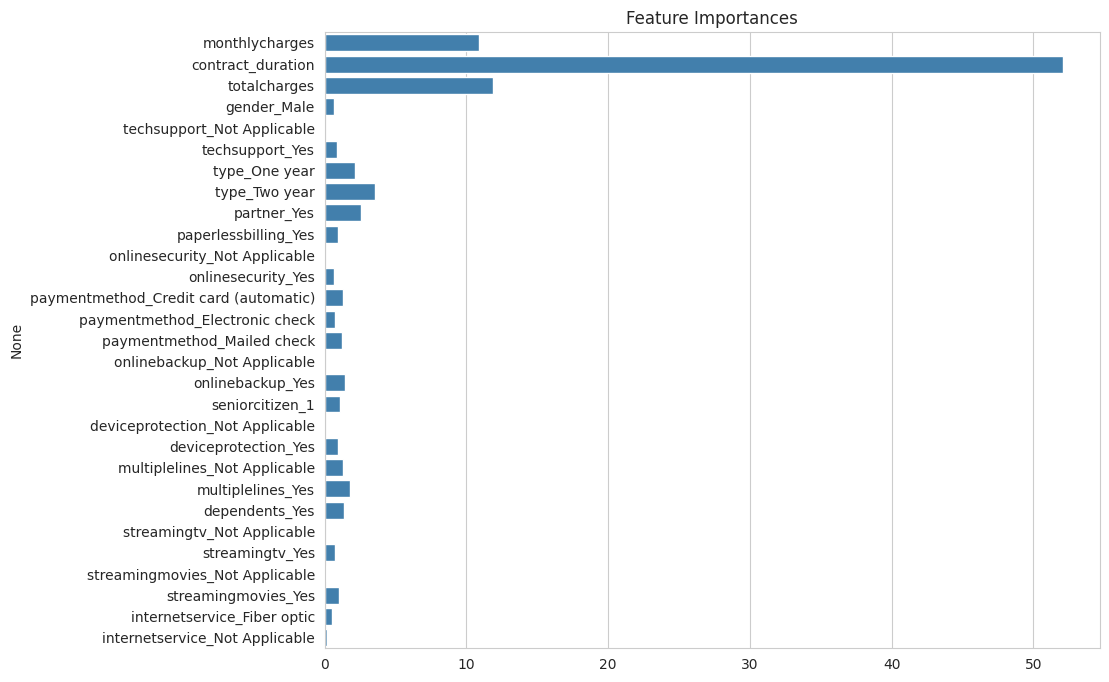

In [96]:
#Анализ важности признаков

feature_importances = best_model.get_feature_importance()
plt.figure(figsize=(10, 8))
sns.barplot(y=X_train_transformed_df.columns, x=feature_importances)
plt.title('Feature Importances')
plt.show()

Наиболее важными признаками являются - длительность контракта , следом идут общие и помесячные траты. Эти Признаки являются ключевыми для принятия решений моделью.

##Сохранение модели

In [97]:
#saving model

to_save = {
    'preprocessor': preprocessor,
    'model': best_model,
    'new_numeric_features': new_numeric_features,
    'new_categorical_features': new_categorical_features.tolist()
}

# Save
save_path = '/content/drive/MyDrive/datasets/models/full_pipeline.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(to_save, file)

# **Шаг 8. Заключение и рекомендации для заказчика**

Основной целью этого проекта была разработка прогнозной модели для «ТелеДом», телекоммуникационного оператора, стремящегося сократить отток клиентов, предлагая акции и специальные условия тем, кто планирует прекратить свои услуги. Цель и задачи проекта выполнены.

Проект начался с загрузки предоставленных наборов данных и проведения первоначальной проверки для понимания структуры, качества и типов доступной информации. Для каждого кадра данных был проведен углубленный исследовательский анализ с последующей необходимой предварительной обработкой данных. Этот этап включал выявление и обработку пропущенных значений, выбросов (менее 3 %) и обеспечение того, чтобы общее качество данных было подходящим для моделирования. Анализ позволил получить представление о доступных функциях и их потенциальной полезности для прогнозирования оттока клиентов.

Выбранные функции были объединены в единый фрейм данных с использованием ключа для унификации данных, что позволило более упростить процесс анализа и моделирования.

Был выполнен дальнейший исследовательский анализ объединенного кадра данных, визуализация распределения признаков и выполнение корреляционного анализа для понимания взаимосвязей между переменными. Все корреляции с оттоком не были сильными. Наиболее значимыми результатами являются продолжительность контракта (0,375). Такая положительная корреляция предполагает, что более длительный срок контракта связан с более высоким уровнем оттока клиентов. Это может указывать на проблемы с обязательствами клиентов или неудовлетворенность ими с течением времени.

Общие расходы (0,303): демонстрирует умеренную положительную корреляцию с оттоком. Более высокие общие расходы могут привести к более высокому оттоку, возможно, из-за воспринимаемой ценности или финансовых ограничений с точки зрения клиента. Партнер (0,227) и «Ежемесячные сборы» (0,226): оба демонстрируют одинаковый уровень положительной корреляции с оттоком. Наличие партнера и более высокие ежемесячные платежи умеренно способствуют оттоку клиентов. Это может отразиться на финансовом бремени и динамике принятия решений в домохозяйствах.

Данные были подготовлены для обучения модели, которое включало разделение на обучающий и тестовый наборы, масштабирование числовых характеристик и кодирование категориальных переменных. Эта подготовка была адаптирована с учетом требований прогнозных моделей и конкретных характеристик данных.

Было обучено несколько моделей (CatBoost и логистическа регрессия, причем обе модели подверглись настройке гиперпараметров для оптимизации их производительности. Этот процесс включал оценку различных алгоритмов и их конфигураций, чтобы найти наиболее эффективное решение для прогнозирования оттока клиентов.

После обучения была выбрана наиболее эффективная модель на основе ее показателей производительности, включая  (ROC AUC). Затем выбранная модель была протестирована на отдельном наборе тестовых данных, чтобы подтвердить ее прогностическую способность и обобщаемость.

В рамках проекта была успешно разработана прогнозирующая модель, способная с высокой точностью идентифицировать клиентов, которые могут уйти. Самая эффективная модель CatBoost достигла значения ROC AUC 0,928  на тестовом наборе, что указывает на ее хорошую способность точно классифицировать клиентов.

**Рекомендации Заказчику**

По результатам проекта «ТелеДом» рекомендуется внедрить прогнозную модель для превентивного выявления клиентов из группы риска. Поступая таким образом, компания может ориентировать этих людей на специальные предложения, рекламные акции или персонализированные коммуникационные стратегии, направленные на сохранение их бизнеса. Учитывая результаты корреляции, вот краткие рекомендации для «ТелеДома» по снижению оттока клиентов:

- Приоритизируйте продолжительность контракта. Более длительные контракты с меньшей вероятностью будут отброшены. Предложение стимулов для более длительных обязательств может снизить уровень оттока сотрудников.

- Пересмотрите цены и сборы. Высокие общие и ежемесячные расходы связаны с более высоким оттоком клиентов. Рассмотрите возможность пересмотра стратегий ценообразования, особенно для дорогостоящих планов, чтобы убедиться, что они предлагают оптимальное соотношение цены и качества.

- Сосредоточив внимание на этих направлениях, «ТелеДом» может реализовать целевые стратегии, позволяющие эффективно снизить отток клиентов и повысить общую удовлетворенность и лояльность клиентов.

# Загрузка модели и предсказание для случайного пользователя

##Подготовка данных для предсказания

В этом разделе будут произведены следующие шаги
*   Создание исходных таблиц и заполнение случайными данными одного абонента
*   Предобработка для всех датасетов, такие же как на исходных данных
*   Соединение датафреймов в общий датафрейм
*   Выполнения предобработки и трансформации точно также как и на исходном общем датафрейме
*   Загрузка модели
*   Предсказание для этих данных








In [98]:
contract_path = '/content/drive/MyDrive/datasets/contract_new.csv'
internet_path = '/content/drive/MyDrive/datasets/internet_new.csv'
phone_path = '/content/drive/MyDrive/datasets/phone_new.csv'
personal_path = '/content/drive/MyDrive/datasets/personal_new.csv'
model_path = '/content/drive/MyDrive/datasets/models/full_pipeline.pkl'

In [99]:
# Load the data for a specific customer
contract_test = pd.read_csv(contract_path)
internet_test = pd.read_csv(internet_path)
phone_test = pd.read_csv(phone_path)
personal_test = pd.read_csv(personal_path)

In [100]:
# # Seed for reproducibility
 # Setting the random seed
rng = np.random.default_rng(RANDOM_STATE)

In [101]:
#Finding the intersection of unique customerIDs across all dataframes to ensure the selected customerID is present in each dataframe
common_ids = set(contract_test['customerID'].unique()) & set(internet_test['customerID'].unique()) & \
             set(phone_test['customerID'].unique()) & set(personal_test['customerID'].unique())

In [102]:
# Selecting a random customerID from the intersection
# random_id = np.random.choice(list(common_ids))
random_id = rng.choice(list(common_ids))

In [103]:
# Filtering each dataframe for the selected customerID
contract_test = contract_test[contract_test['customerID'] == random_id]
internet_test = internet_test[internet_test['customerID'] == random_id]
phone_test = phone_test[phone_test['customerID'] == random_id]
personal_test = personal_test[personal_test['customerID'] == random_id]

In [104]:
contract_test.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6996,4174-LPGTI,2016-05-01,No,One year,Yes,Bank transfer (automatic),66.5,3142.12


In [105]:
internet_test.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5477,4174-LPGTI,DSL,No,Yes,No,Yes,No,Yes


In [106]:
phone_test.head()

,customerID,MultipleLines
6320,4174-LPGTI,No


In [107]:
personal_test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
6996,4174-LPGTI,Female,0,Yes,Yes


In [108]:


def predict_for_new_customer(contract: pd.DataFrame, internet: pd.DataFrame, phone: pd.DataFrame, personal: pd.DataFrame, model_path: str) -> pd.DataFrame:
    """
    Predict churn for new customers using a saved model and provided data.

    Args:
        contract (pd.DataFrame): Contract information dataframe.
        internet (pd.DataFrame): Internet service information dataframe.
        phone (pd.DataFrame): Phone service information dataframe.
        personal (pd.DataFrame): Personal information dataframe.
        model_path (str): Path to the saved model file.

    Returns:
        pd.DataFrame: DataFrame containing customer IDs and corresponding predictions for churn.
    """
    # Preprocessing function for contract dataset
    def preprocess_contract(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the contract data.
        Args:
            df (pd.DataFrame): Input dataframe with contract information.
        Returns:
            pd.DataFrame: Preprocessed dataframe.
        """
        df.columns = df.columns.str.lower()
        df.drop_duplicates(inplace=True)
        df['begindate'] = pd.to_datetime(df['begindate'])
        df['enddate'] = pd.to_datetime(df['enddate'], errors='coerce')
        df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce').fillna(0)
        df['churn'] = df['enddate'].notna().astype(int)
        replacement_date = pd.Timestamp('2020-02-01')
        df['enddate'] = df['enddate'].fillna(replacement_date)
        return df

    # Preprocessing function for other datasets
    def preprocess_others(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess data by converting column names to lowercase.
        Args:
            df (pd.DataFrame): Input dataframe to preprocess.
        Returns:
            pd.DataFrame: Preprocessed dataframe with lowercase column names.
        """
        df.columns = df.columns.str.lower()
        return df

    # Merge function
    def merge_dataframes(contract: pd.DataFrame, personal: pd.DataFrame, internet: pd.DataFrame, phone: pd.DataFrame) -> pd.DataFrame:
        """
        Merge dataframes on 'customerid' with an outer join to include all records.
        Args:
            contract (pd.DataFrame): Contract information dataframe.
            personal (pd.DataFrame): Personal information dataframe.
            internet (pd.DataFrame): Internet service information dataframe.
            phone (pd.DataFrame): Phone service information dataframe.

        Returns:
            pd.DataFrame: Merged dataframe containing all information.
        """
        merged_df = contract.merge(personal, on='customerid', how='outer')
        merged_df = merged_df.merge(internet, on='customerid', how='outer')
        final_df = merged_df.merge(phone, on='customerid', how='outer')
        return final_df

    # Preprocessing merged data
    def preprocess_merged_data(df: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess the merged dataframe.
        Args:
            df (pd.DataFrame): Merged dataframe to preprocess.
        Returns:
            pd.DataFrame: Preprocessed dataframe ready for analysis or modeling.
        """
        df['contract_duration'] = (df['enddate'] - df['begindate']).dt.days
        cols = df.select_dtypes(include=['object', 'float']).columns.tolist()
        additional_cols = ['churn', 'contract_duration', 'seniorcitizen']
        cols = list(set(cols + additional_cols))
        df = df[cols].copy()
        df.drop_duplicates(keep=False, inplace=True)
        df['multiplelines'].fillna('Not Applicable', inplace=True)
        internet_service_columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                                    'techsupport', 'streamingtv', 'streamingmovies']
        df[internet_service_columns] = df[internet_service_columns].fillna('Not Applicable')
        df['seniorcitizen'] = df['seniorcitizen'].astype(str)
        df.set_index('customerid', inplace=True)
        return df

    # Load saved model and preprocessing components
    def load_model_and_preprocessor(model_path: str) -> Dict[str, Any]:
        """
        Load saved model and preprocessing components.
        Args:
            model_path (str): Path to the saved model file.
        Returns:
            Dict[str, Any]: Dictionary containing the loaded model and preprocessing components.
        """
        with open(model_path, 'rb') as file:
            saved_model = pickle.load(file)
        return saved_model

    # Preprocess all datasets
    contract = preprocess_contract(contract)
    internet = preprocess_others(internet)
    personal = preprocess_others(personal)
    phone = preprocess_others(phone)

    # Merge datasets
    merged_df = merge_dataframes(contract, personal, internet, phone)

    # Preprocess merged data
    preprocessed_df = preprocess_merged_data(merged_df)
    # Remove 'churn' column before preprocessing new data
    preprocessed_df.drop('churn', axis=1, inplace=True)
    # Load model and preprocessing components
    model_and_preprocessor = load_model_and_preprocessor(model_path)

    # Preprocess new data and make predictions
    def predict_for_new_data(model_and_preprocessor: Dict[str, Any], new_data: pd.DataFrame) -> np.ndarray:
        """
        Preprocess new data and make predictions using the loaded model and preprocessing components.
        Args:
            model_and_preprocessor (Dict[str, Any]): Dictionary containing the loaded model and preprocessing components.
            new_data (pd.DataFrame): New data to make predictions on.
        Returns:
            np.ndarray: Predictions for the new data.
        """
        preprocessor = model_and_preprocessor['preprocessor']
        model = model_and_preprocessor['model']
        preprocessed_data = preprocessor.transform(new_data)
        new_features = model_and_preprocessor['new_numeric_features'] + model_and_preprocessor['new_categorical_features']
        preprocessed_data_df = pd.DataFrame(preprocessed_data, columns=new_features)
        predictions = model.predict(preprocessed_data_df)
        return predictions

    # Make predictions for new data
    predictions = predict_for_new_data(model_and_preprocessor, preprocessed_df)

    # Create a DataFrame with customer IDs and predictions
    customer_ids = preprocessed_df.index
    result_df = pd.DataFrame({'CustomerID': customer_ids, 'Prediction': predictions})

    return result_df






In [109]:

# Call the function with the loaded DataFrames
predictions_df = predict_for_new_customer(contract_test, internet_test, phone_test, personal_test, model_path)
print("Predictions:")
print(predictions_df)

Predictions:
   CustomerID  Prediction
0  4174-LPGTI           0


In [111]:
# # finging real value for this user
real_value = df.loc[random_id, 'churn']

# # print real value
print(f"Real value in original df {random_id}: {real_value}")

Real value in original df 4174-LPGTI: 0


Загрузка модели и предсказание для случайного абонента успешно выполнены.